In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import dill
import gzip
import logging

sys.path.append(os.path.abspath('../../surmise/emulationmethods'))
from AKSGP import Emulator

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        # logging.FileHandler('emulator_train.log', mode='w'),  # Log to file
        logging.StreamHandler()  # Log to console
    ]
)
logger = logging.getLogger(__name__)

# Try mock data

In [2]:
from sklearn.datasets import make_friedman1, make_friedman2
X, y = make_friedman2(n_samples=50, noise=0.0, random_state=0)
emu = Emulator(X=X, Y_mean=y, Y_std=None)
emu.fit(kernel='AKS', nrestarts=5)

Xtest, ytest = make_friedman2(n_samples=10, noise=0.0, random_state=0)
means, std_devs = emu.predict(Xtest)
print("% error:\n", (1.0 - means/ytest.reshape(-1, 1))*100)

print(f"Total wall-clock time: {emu.wallclocktime:.2f} seconds")
print(f"Total cpu time: {emu.totalcputime:.2f} seconds")

2024-08-29 22:21:05 - AKSGP - INFO - Automatic kernel selection opted. Best kernel for each output dimension will be selected from the list of kernels:
   ['Matern12', 'Matern32', 'Matern52', 'RBF']

2024-08-29 22:21:05 - AKSGP - INFO - Shape of training arrays: (45, 4), (45, 1), (45, 1)
2024-08-29 22:21:05 - AKSGP - INFO - Shape of validation arrays: (5, 4), (5, 1), (5, 1)
2024-08-29 22:21:05 - AKSGP - INFO - Training GPs with all available kernels...
2024-08-29 22:21:05 - AKSGP - INFO -   Standardizing input space...
2024-08-29 22:21:05 - AKSGP - INFO -   Standardizing data...
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/ga

% error:
 [[ 1.73272896e-07]
 [-5.81063277e-06]
 [ 8.94820884e-07]
 [-3.85552578e-04]
 [-2.25384327e-05]
 [-3.86531091e-05]
 [-1.65474762e-05]
 [-2.30213055e-04]
 [ 1.47611272e-03]
 [-5.78348709e-06]]
Total wall-clock time: 0.96 seconds
Total cpu time: 1.69 seconds


# Load heavy-ion data

In [3]:
# Load training data
train_dir = 'simulation_data/Grad_Pb-Pb-2760GeV/train'
X = np.loadtxt(os.path.join(train_dir, 'X.txt'))
Ymean = np.loadtxt(os.path.join(train_dir, 'Ymean.txt'))
Ystd = np.loadtxt(os.path.join(train_dir, 'Ystd.txt'))

print(f"Arrays loaded from directory '{train_dir}'.")
print(f"Shapes of loaded arrays: {X.shape}, {Ymean.shape}, {Ystd.shape}")


# Load testing data
test_dir = 'simulation_data/Grad_Pb-Pb-2760GeV/test'

Xval = np.loadtxt(os.path.join(test_dir, 'X.txt'))
Ymeanval = np.loadtxt(os.path.join(test_dir, 'Ymean.txt'))
Ystdval = np.loadtxt(os.path.join(test_dir, 'Ystd.txt'))

print(f"Arrays loaded from directory '{test_dir}'.")
print(f"Shapes of loaded arrays: {Xval.shape}, {Ymeanval.shape}, {Ystdval.shape}")


Arrays loaded from directory 'simulation_data/Grad_Pb-Pb-2760GeV/train'.
Shapes of loaded arrays: (485, 17), (485, 110), (485, 110)
Arrays loaded from directory 'simulation_data/Grad_Pb-Pb-2760GeV/test'.
Shapes of loaded arrays: (93, 17), (93, 110), (93, 110)


# Train emulators

In [4]:
inpsize = 485; numobs= (5, 23, 33, 40, 51, 57, 67, 75, 85, 95, 100, 106);

emu = Emulator(X=X[:inpsize], Y_mean=Ymean[:inpsize, numobs], Y_std=Ystd[:inpsize, numobs])
emu.fit(kernel='AKS', nrestarts=5, seed=13)

print(f"Total wall-clock time: {emu.wallclocktime:.2f} seconds")
print(f"Total cpu time: {emu.totalcputime:.2f} seconds")

2024-08-29 22:21:06 - AKSGP - INFO - Automatic kernel selection opted. Best kernel for each output dimension will be selected from the list of kernels:
   ['Matern12', 'Matern32', 'Matern52', 'RBF']

2024-08-29 22:21:06 - AKSGP - INFO - Shape of training arrays: (436, 17), (436, 12), (436, 12)
2024-08-29 22:21:06 - AKSGP - INFO - Shape of validation arrays: (49, 17), (49, 12), (49, 12)
2024-08-29 22:21:06 - AKSGP - INFO - Training GPs with all available kernels...
2024-08-29 22:21:06 - AKSGP - INFO -   Standardizing input space...
2024-08-29 22:21:06 - AKSGP - INFO -   Standardizing data...
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-package

Total wall-clock time: 128.38 seconds
Total cpu time: 911.23 seconds


In [5]:
import pandas as pd
test = tuple(np.random.randint(0, 93, 10).flatten())

Ymean_test =  Ymean[test, :]
Ymean_test =  Ymean_test[:, numobs]
Ystd_test =  Ystd[test, :]
Ystd_test =  Ystd_test[:, numobs]

Ymeanval_test =  Ymeanval[test, :]
Ymeanval_test =  Ymeanval_test[:, numobs]
Ystdval_test =  Ystdval[test, :]
Ystdval_test =  Ystdval_test[:, numobs]

pd.set_option('display.float_format', '{:,.7f}'.format)
print("Predictions on training set ----------------->")
# Predict with standard deviation
means, std_devs = emu.predict(X[test, :])

df_means_error = (1- means/Ymean_test)*100
df_std_ratio = std_devs/Ystd_test
df_means_error_rounded = pd.DataFrame(df_means_error).round(6)
df_std_ratio_rounded = pd.DataFrame(df_std_ratio).round(6)

print("  % error in means:")
print(df_means_error_rounded.to_string(index=False, header=False))
print("\n  ratio of std:")
print(df_std_ratio_rounded.to_string(index=False, header=False))


# print("  Original means:\n", Ymeanval_test,"\n")
# print("  Predicted means:\n", means,"\n")

# print("  Original standard deviations:\n", Ystdval_test,"\n")
# print("  Predicted standard deviations:\n", std_devs,"\n")


print("\nPredictions on test set ----------------->")
# Predict with standard deviation
means, std_devs = emu.predict(Xval[test, :])

df_means_error = (1- means/Ymeanval_test)*100
df_std_ratio = (std_devs/Ystdval_test)
df_means_error_rounded = pd.DataFrame(df_means_error).round(6)
df_std_ratio_rounded = pd.DataFrame(df_std_ratio).round(6)


print("  % error in means:")
print(df_means_error_rounded.to_string(index=False, header=False))
print("\n  ratio of std:")
print(df_std_ratio_rounded.to_string(index=False, header=False))

# print("  Original means:\n", Ymeanval_test,"\n")
# print("  Predicted means:\n", means,"\n")

# print("  Original standard deviations:\n", Ystdval_test,"\n")
# print("  Predicted standard deviations:\n", std_devs,"\n")


2024-08-29 22:23:16 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Predictions on training set ----------------->
  % error in means:
-0.0830850 -0.0104730  0.2761080  0.2011640  0.0375820 -0.0075770 -0.0246260 -0.0392040  7.8217180 -0.4106390 -4.1927530  -3.1736680
-0.2894930 -0.0740560 -0.4411620 -0.5161020 -0.3877640  0.0132180  0.0258580 -0.0226840  8.6013960  0.2700390 -1.1579790  -4.2225400
 0.1394080 -0.0126550  0.0176810  0.1659360  0.1609760  0.0029570  0.0128400  0.0314390  0.6504980 -2.1944090 -4.7443680  -5.2483310
 0.6453980  0.1056900  0.4388520  0.8241460  0.6366740  0.0295930  0.0347680  0.0304590 -0.1372510 -1.8700910  1.3399320 -13.2081290
-0.0085960  0.0080120  0.1608360  0.1363880 -0.0222490  0.0546580  0.0502160  0.0337490  1.1795990 -0.5409240 -4.1546590  -0.4332260
 0.3664380  0.0609560  0.1199660  0.0986020  0.5176010  0.0034310  0.0050270  0.0157610 -5.0473480 -0.9898860 -1.4155270  -2.6028050
 0.3311850  0.1068280  0.4193080  0.2079120  0.2215430  0.0545540  0.1902170  0.0952170 -6.7899240  1.0989040 -1.2775140  -3.3519010
 0

In [6]:
min_values = np.min(X, axis=0)
max_values = np.max(X, axis=0)
X_test = np.array([np.linspace(min_val, max_val, 100) for min_val, max_val in zip(min_values, max_values)]).T

y_pred, y_std = emu.predict(X_test)

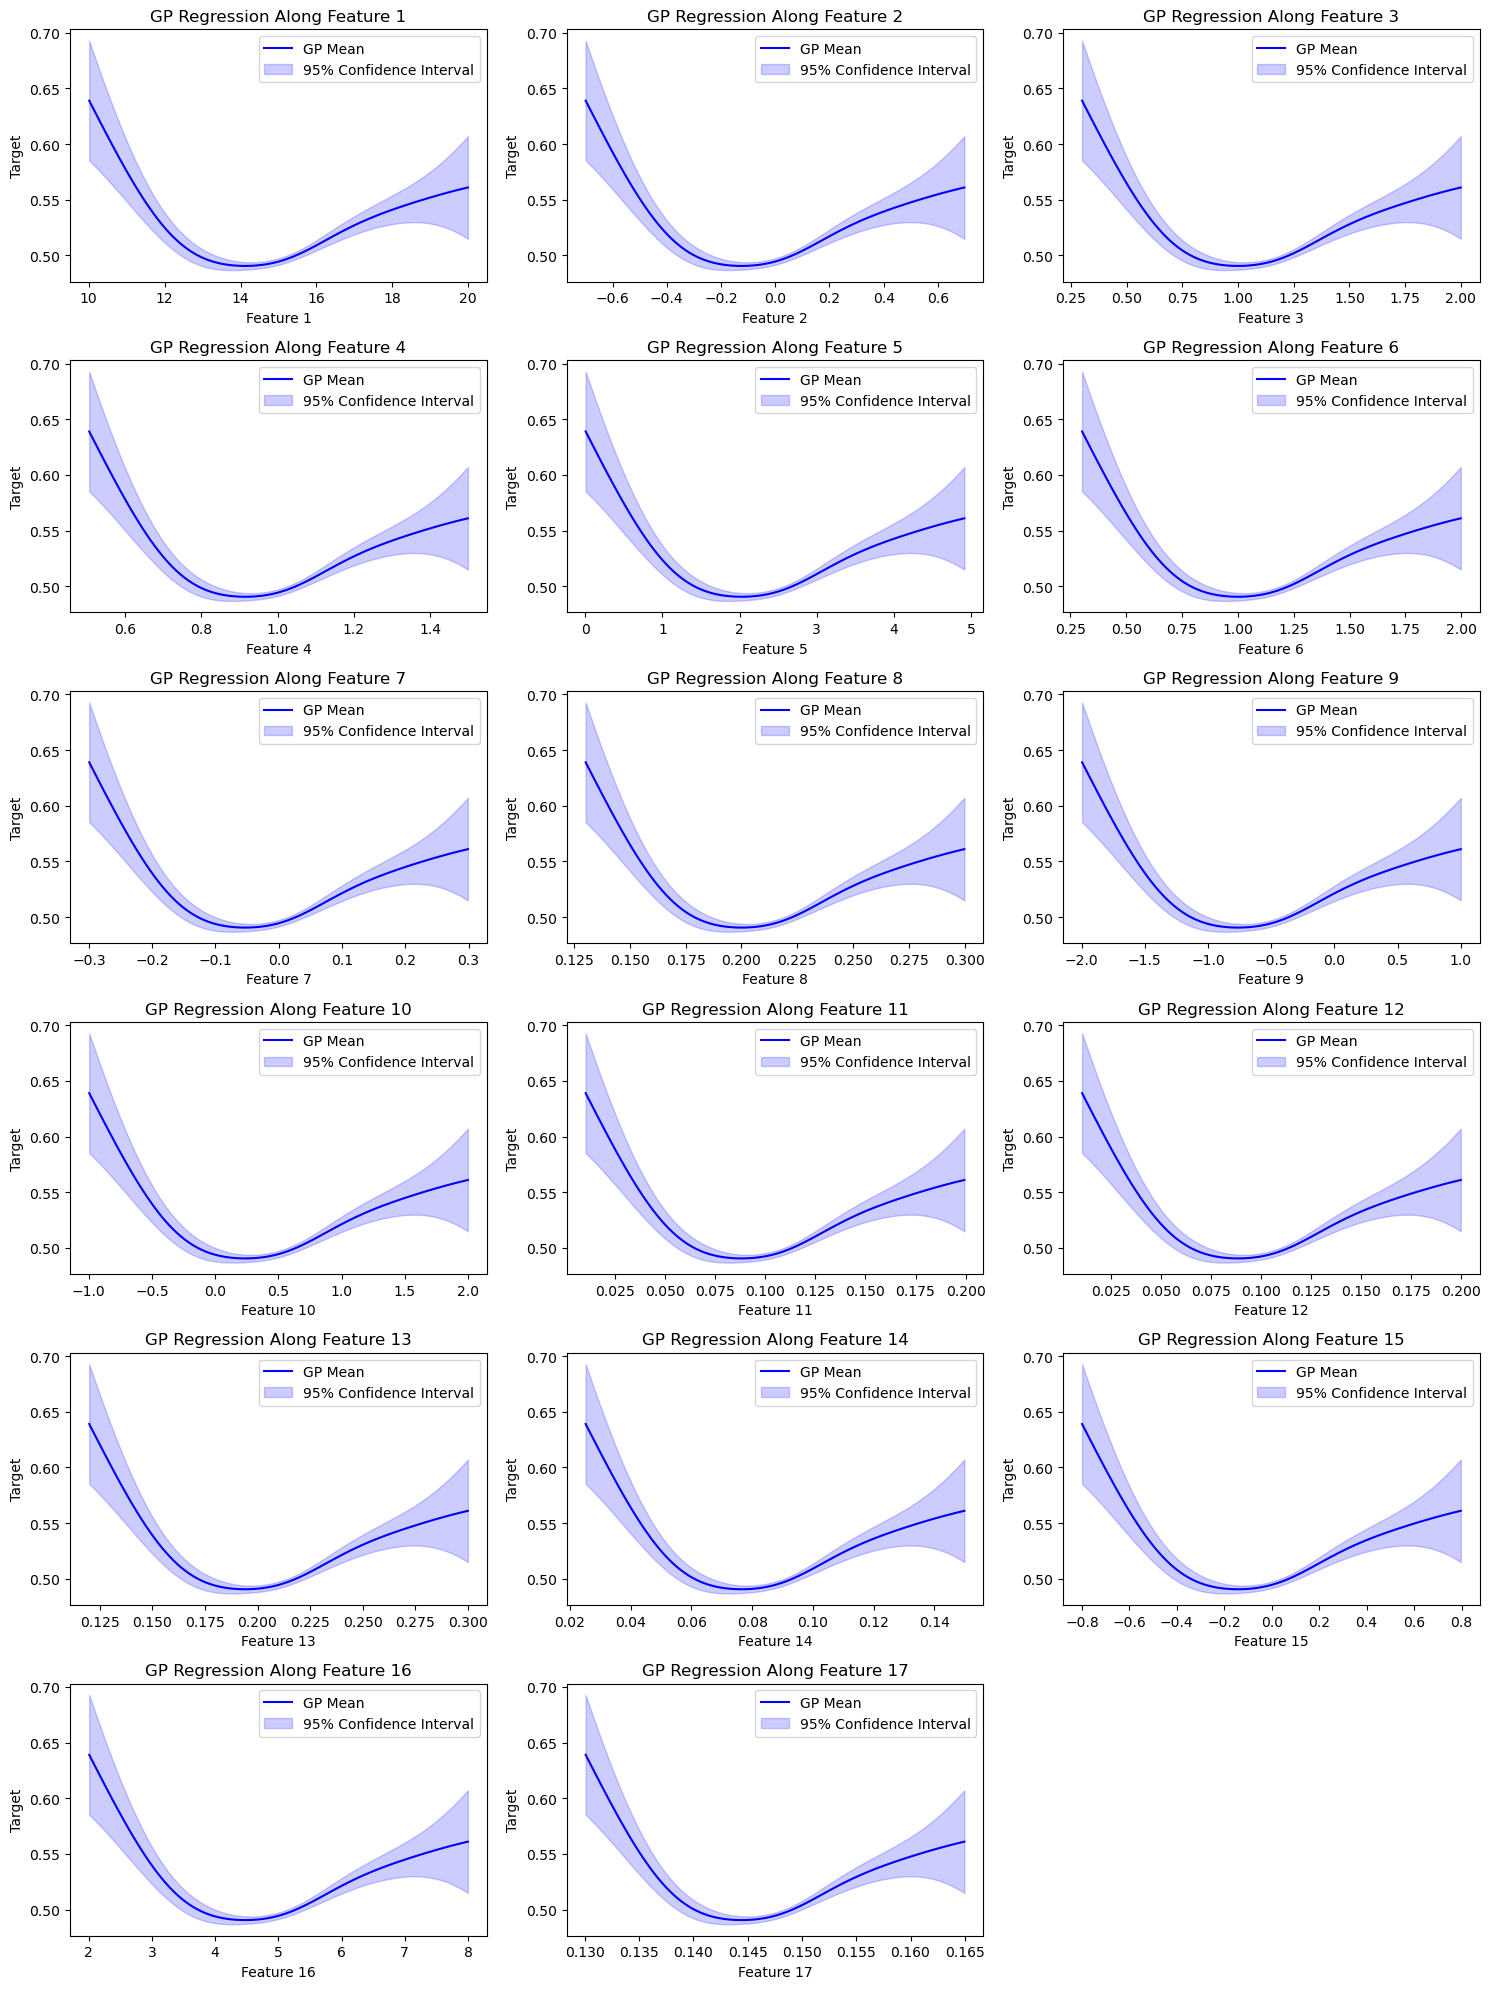

In [7]:
numobs= (5, 23, 33, 40, 51, 57, 67, 75, 85, 95, 100, 106)
# Set up the subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
axes = axes.flatten()

# Loop through each feature
for param_no in range(X.shape[1]):
    obs_no = 5  # Adjust this if you want to visualize different observations
    
    axes[param_no].plot(X_test[:, param_no], y_pred[:, obs_no], 'b-', label='GP Mean')
    # pp = obs_no+1
    # axes[param_no].plot(X_test[:, param_no+1], y_pred[:, pp], 'g-')
    # axes[param_no].plot(X_test[:, param_no], y_pred[:, pp], 'g-')
    axes[param_no].fill_between(X_test[:, param_no], 
                                y_pred[:, obs_no] - 1.96 * y_std[:, obs_no], 
                                y_pred[:, obs_no] + 1.96 * y_std[:, obs_no], 
                                alpha=0.2, color='blue', label='95% Confidence Interval')
    axes[param_no].set_xlabel(f'Feature {param_no + 1}')
    axes[param_no].set_ylabel('Target')
    axes[param_no].set_title(f'GP Regression Along Feature {param_no + 1}')
    axes[param_no].legend()

# Remove any empty subplots if fewer than 18 features
for i in range(X.shape[1], len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

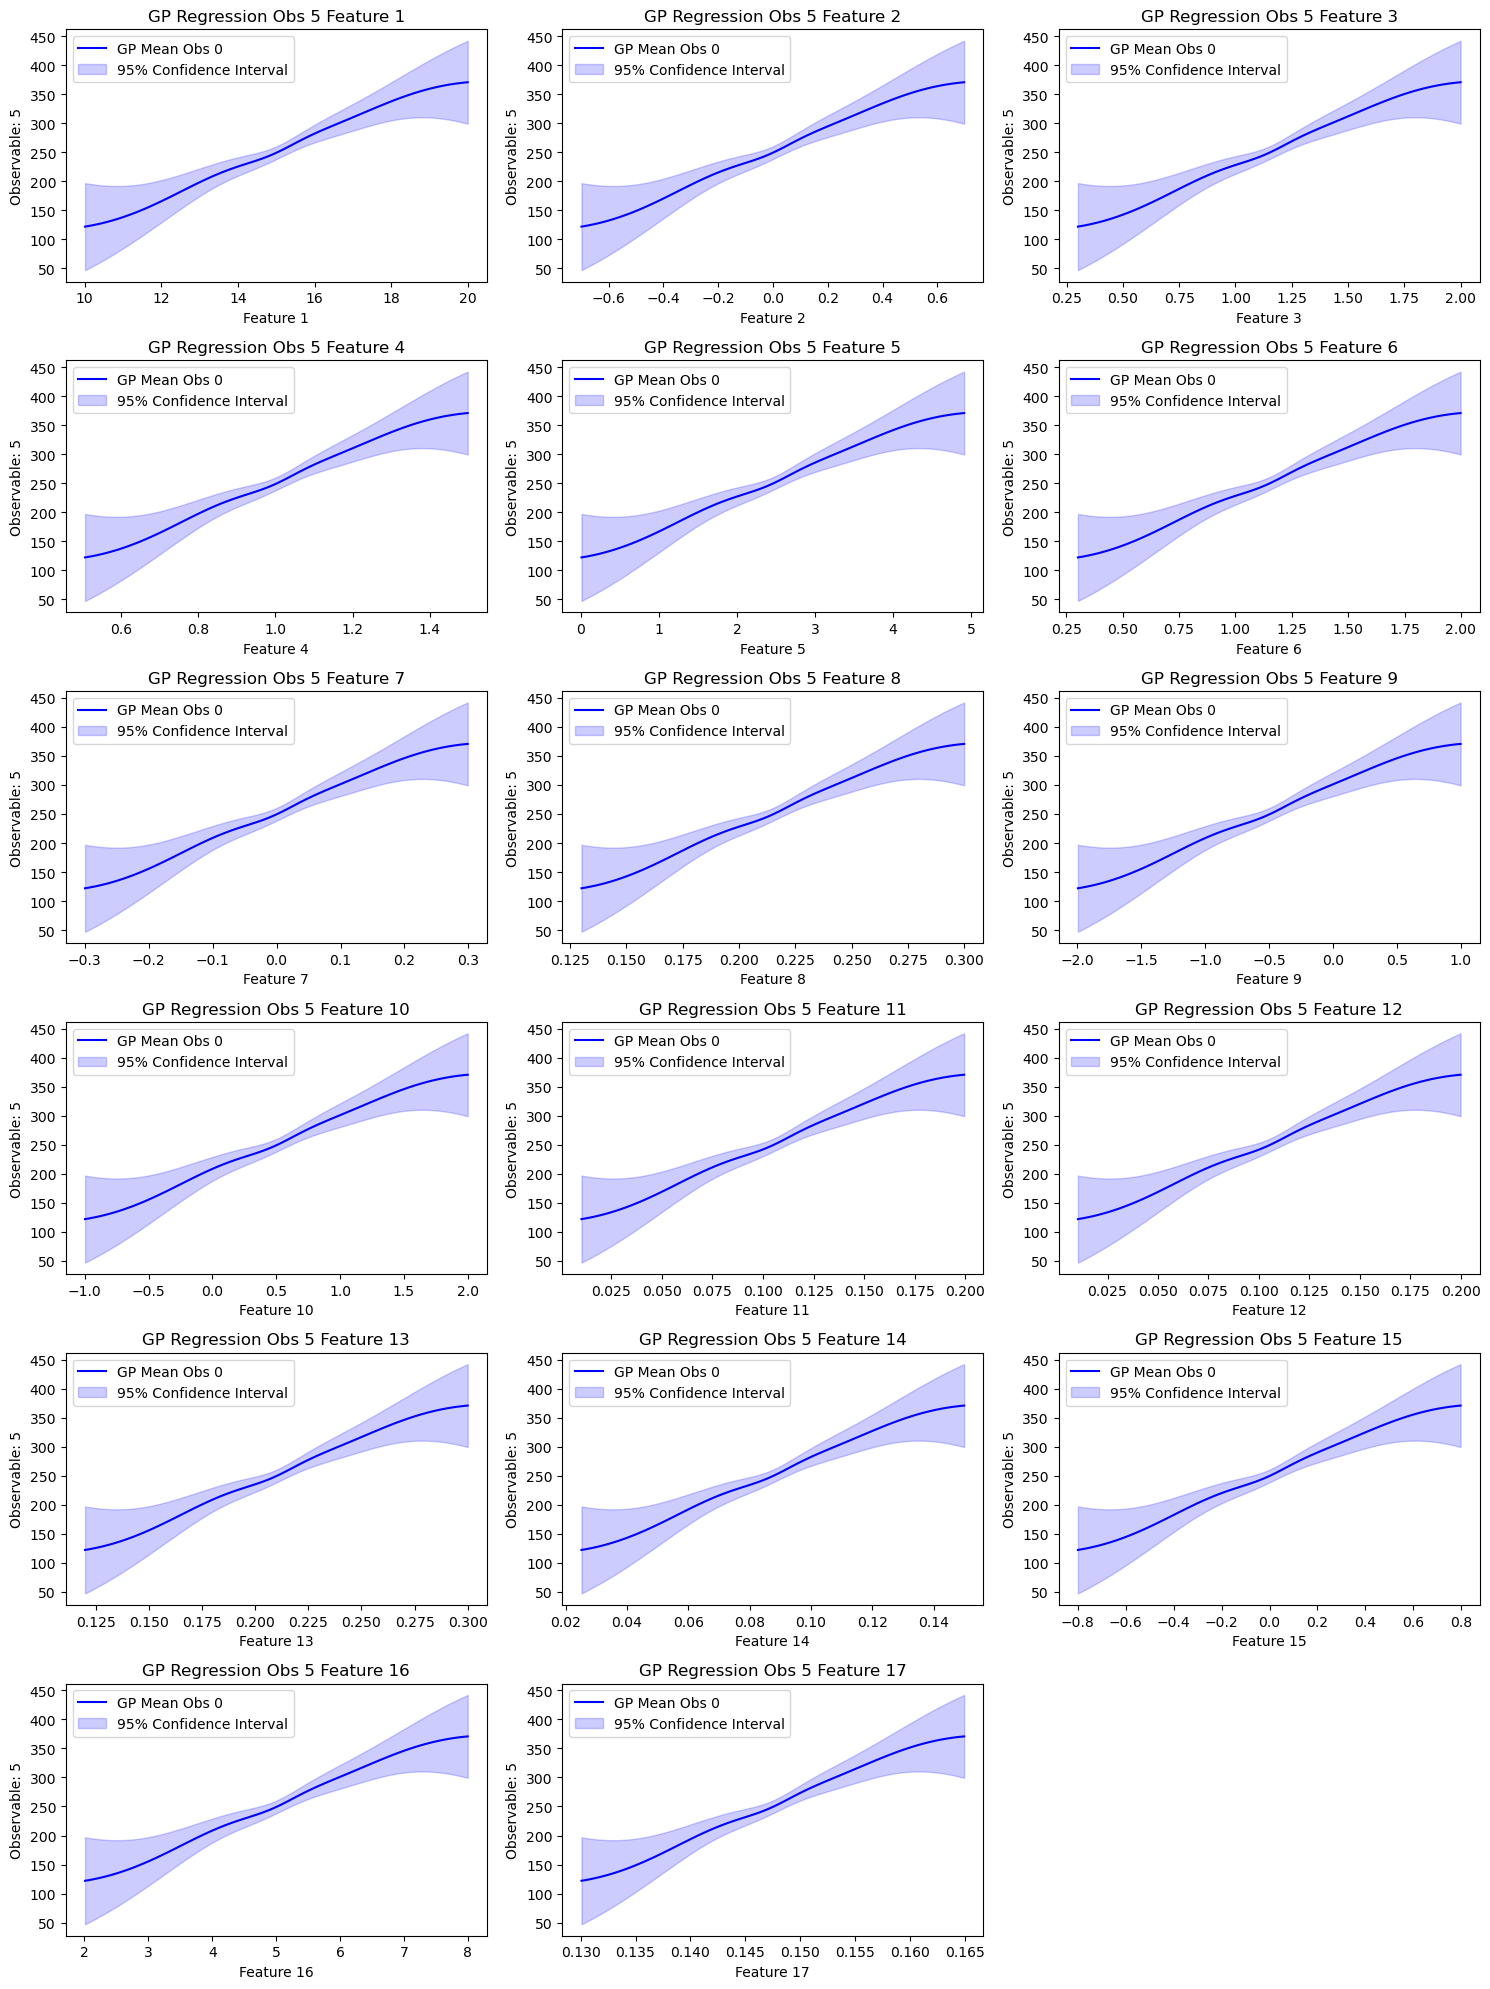

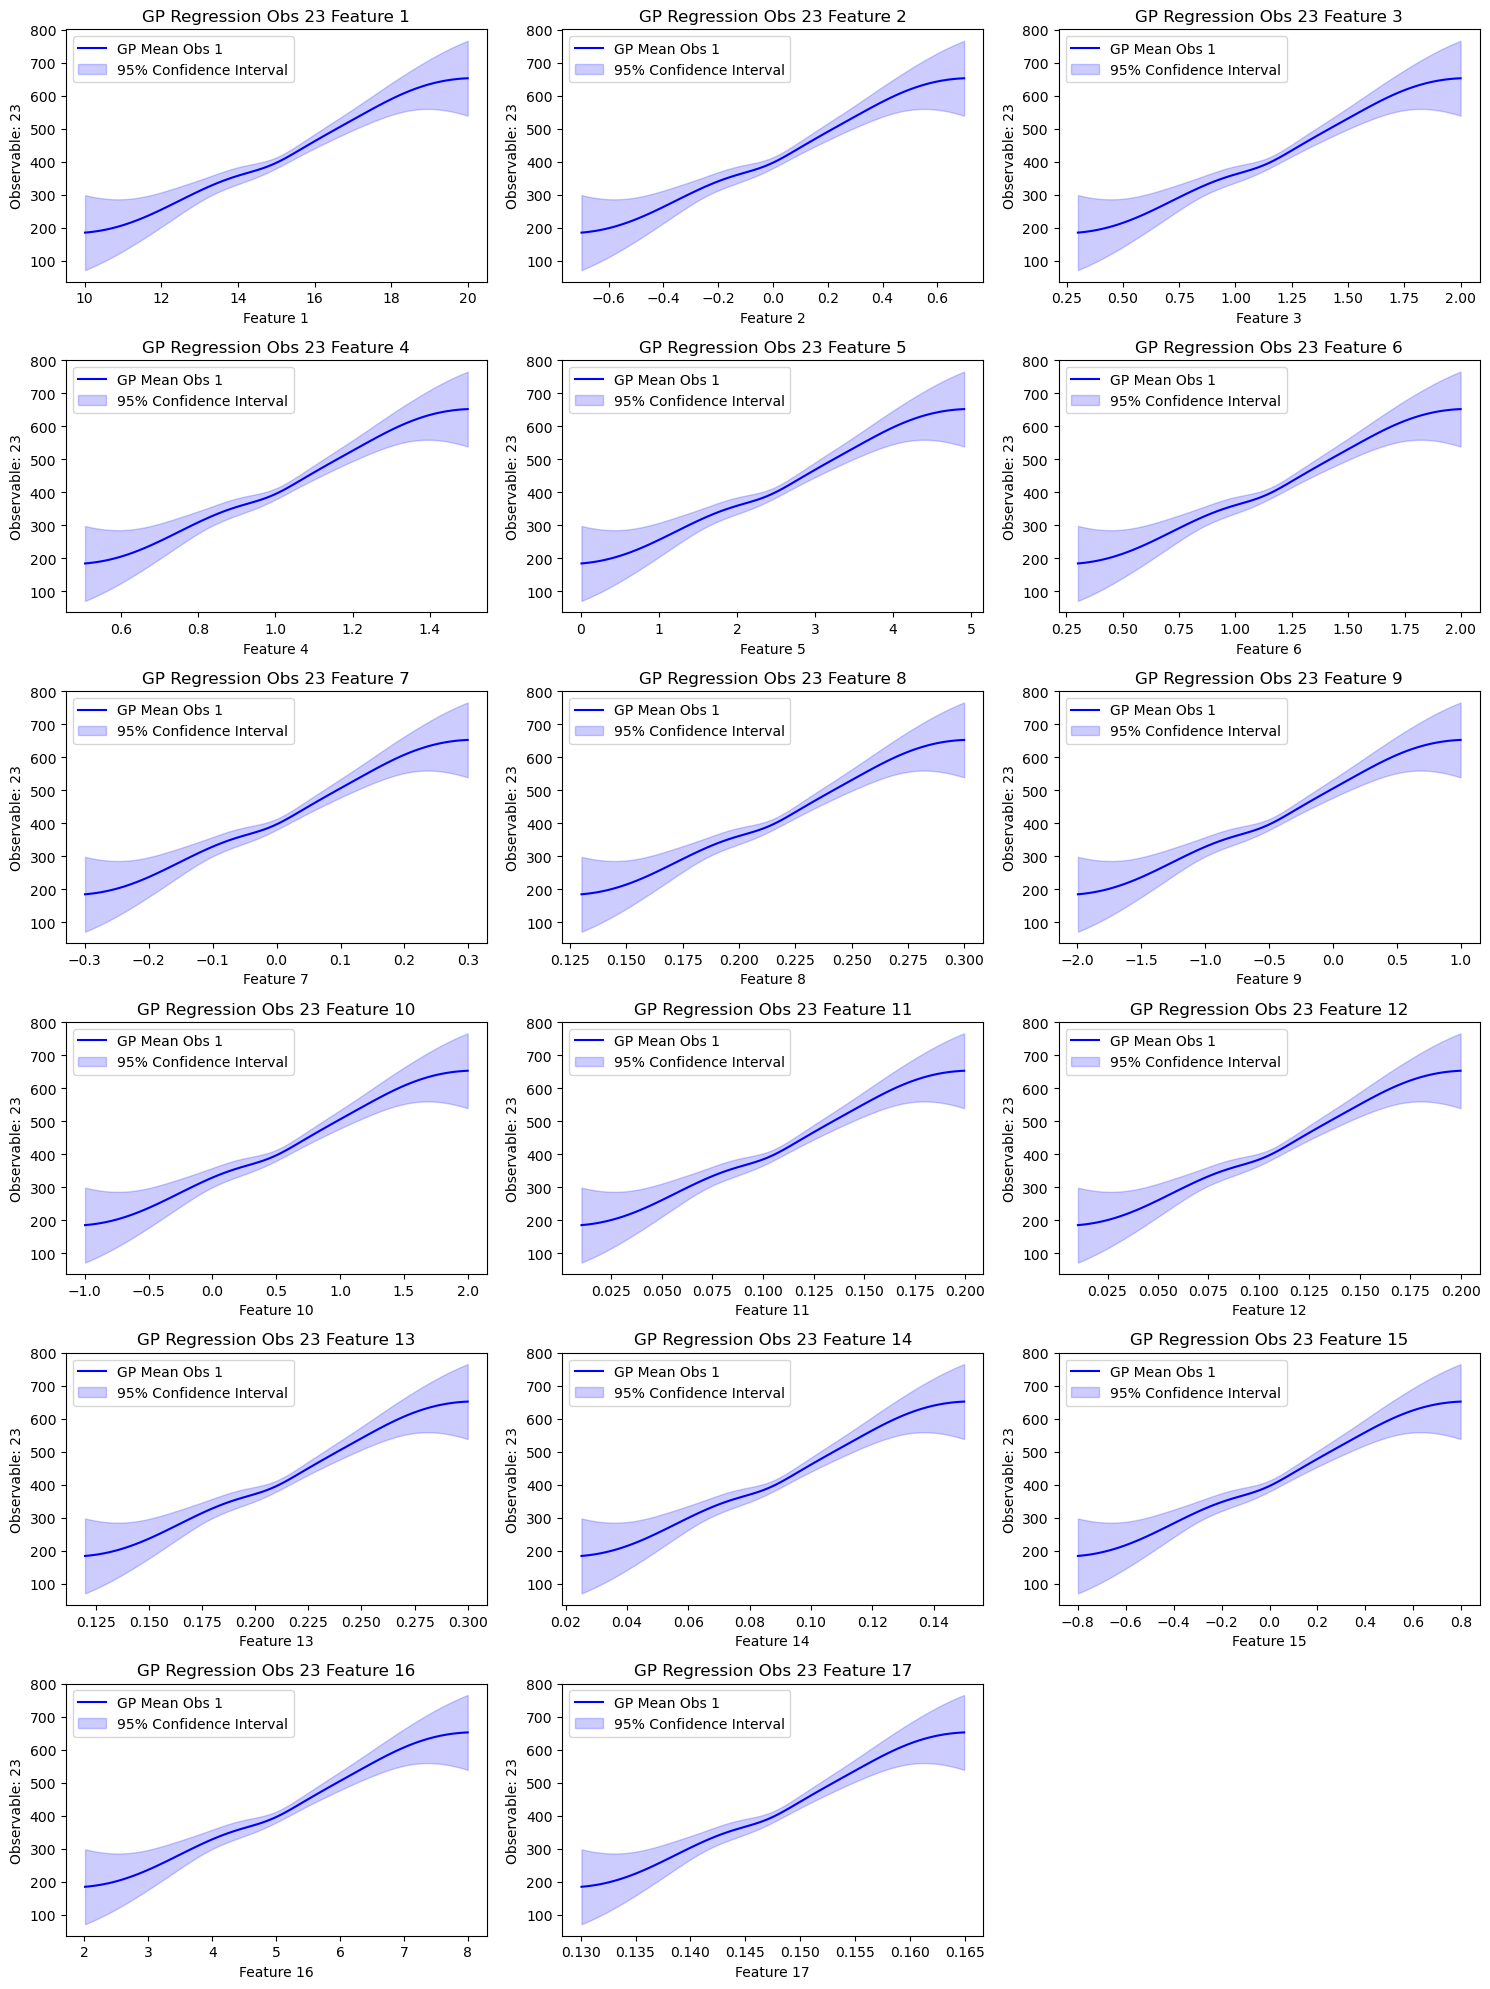

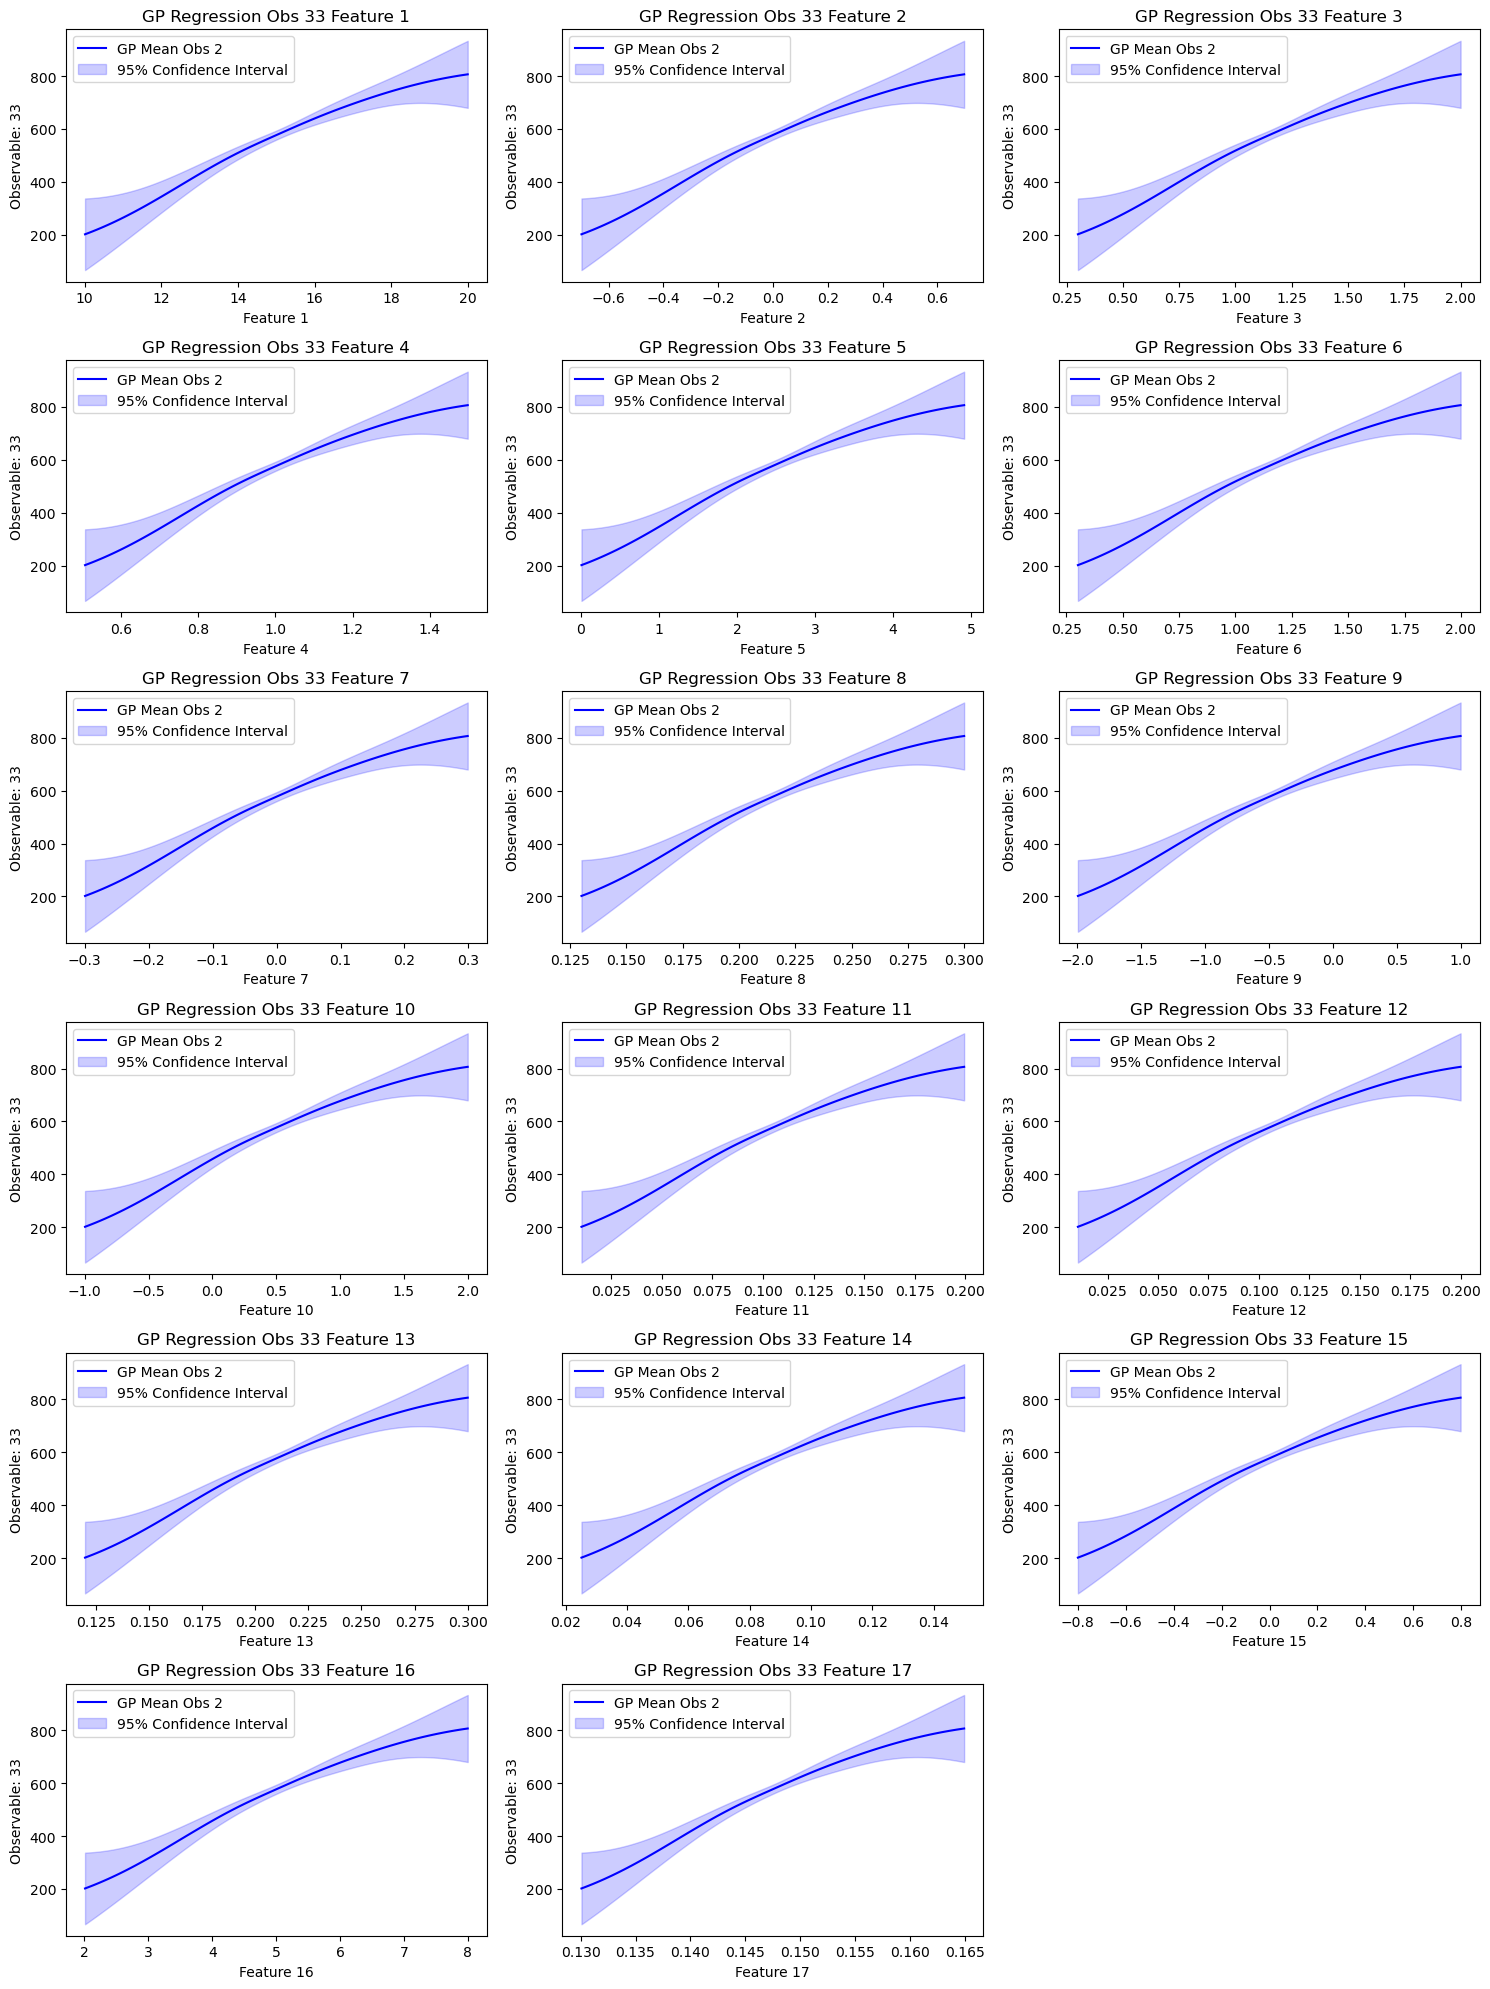

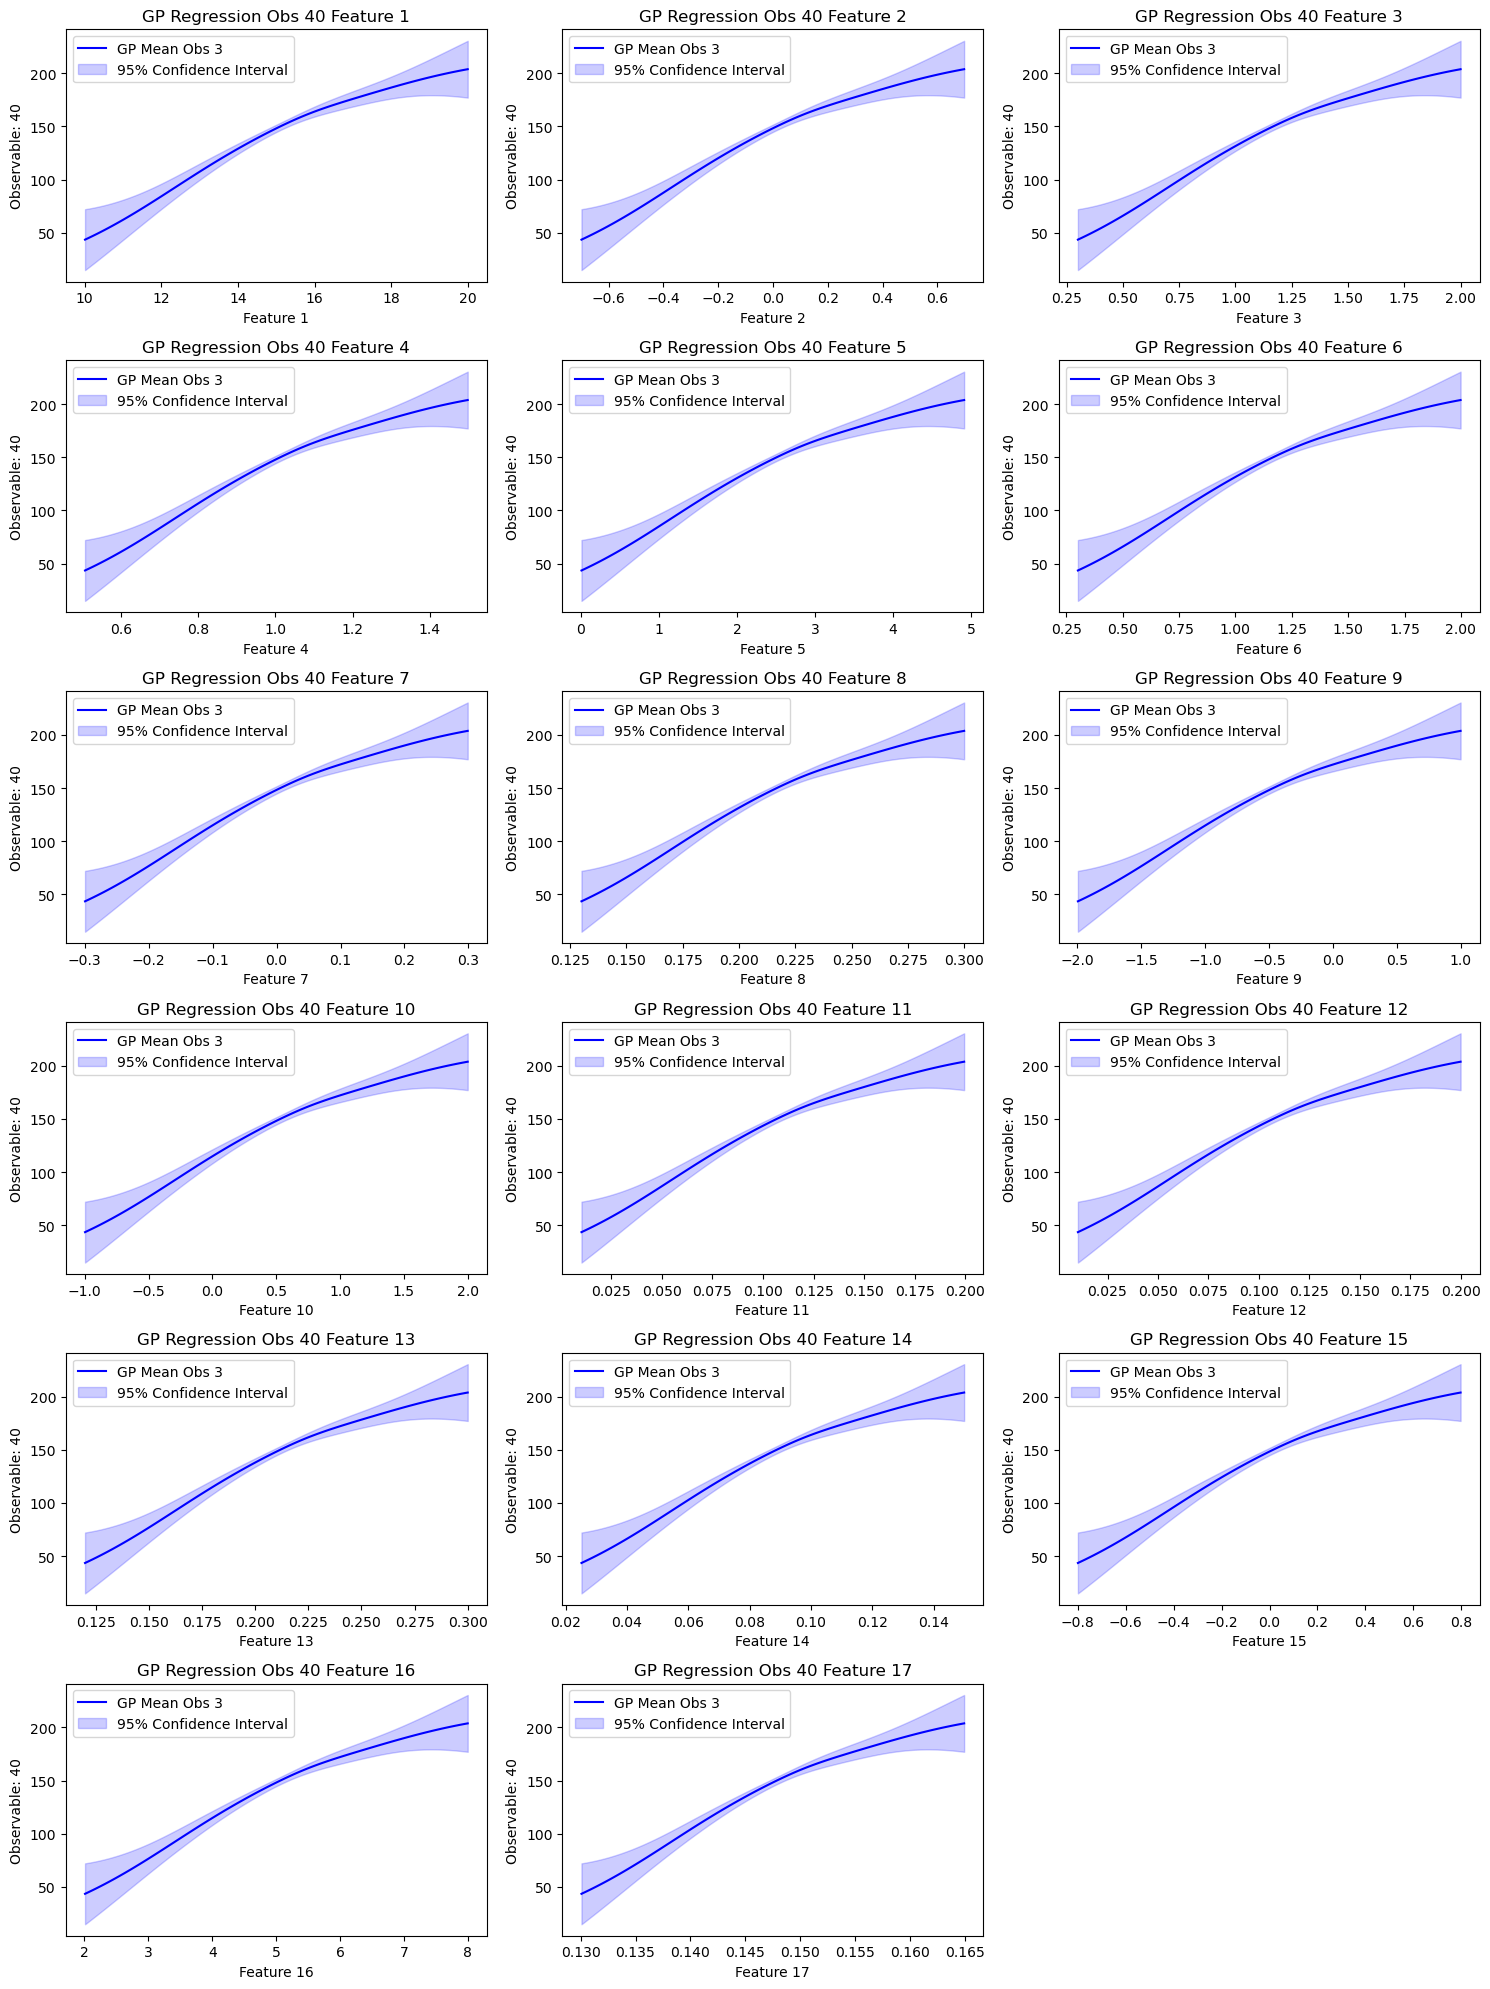

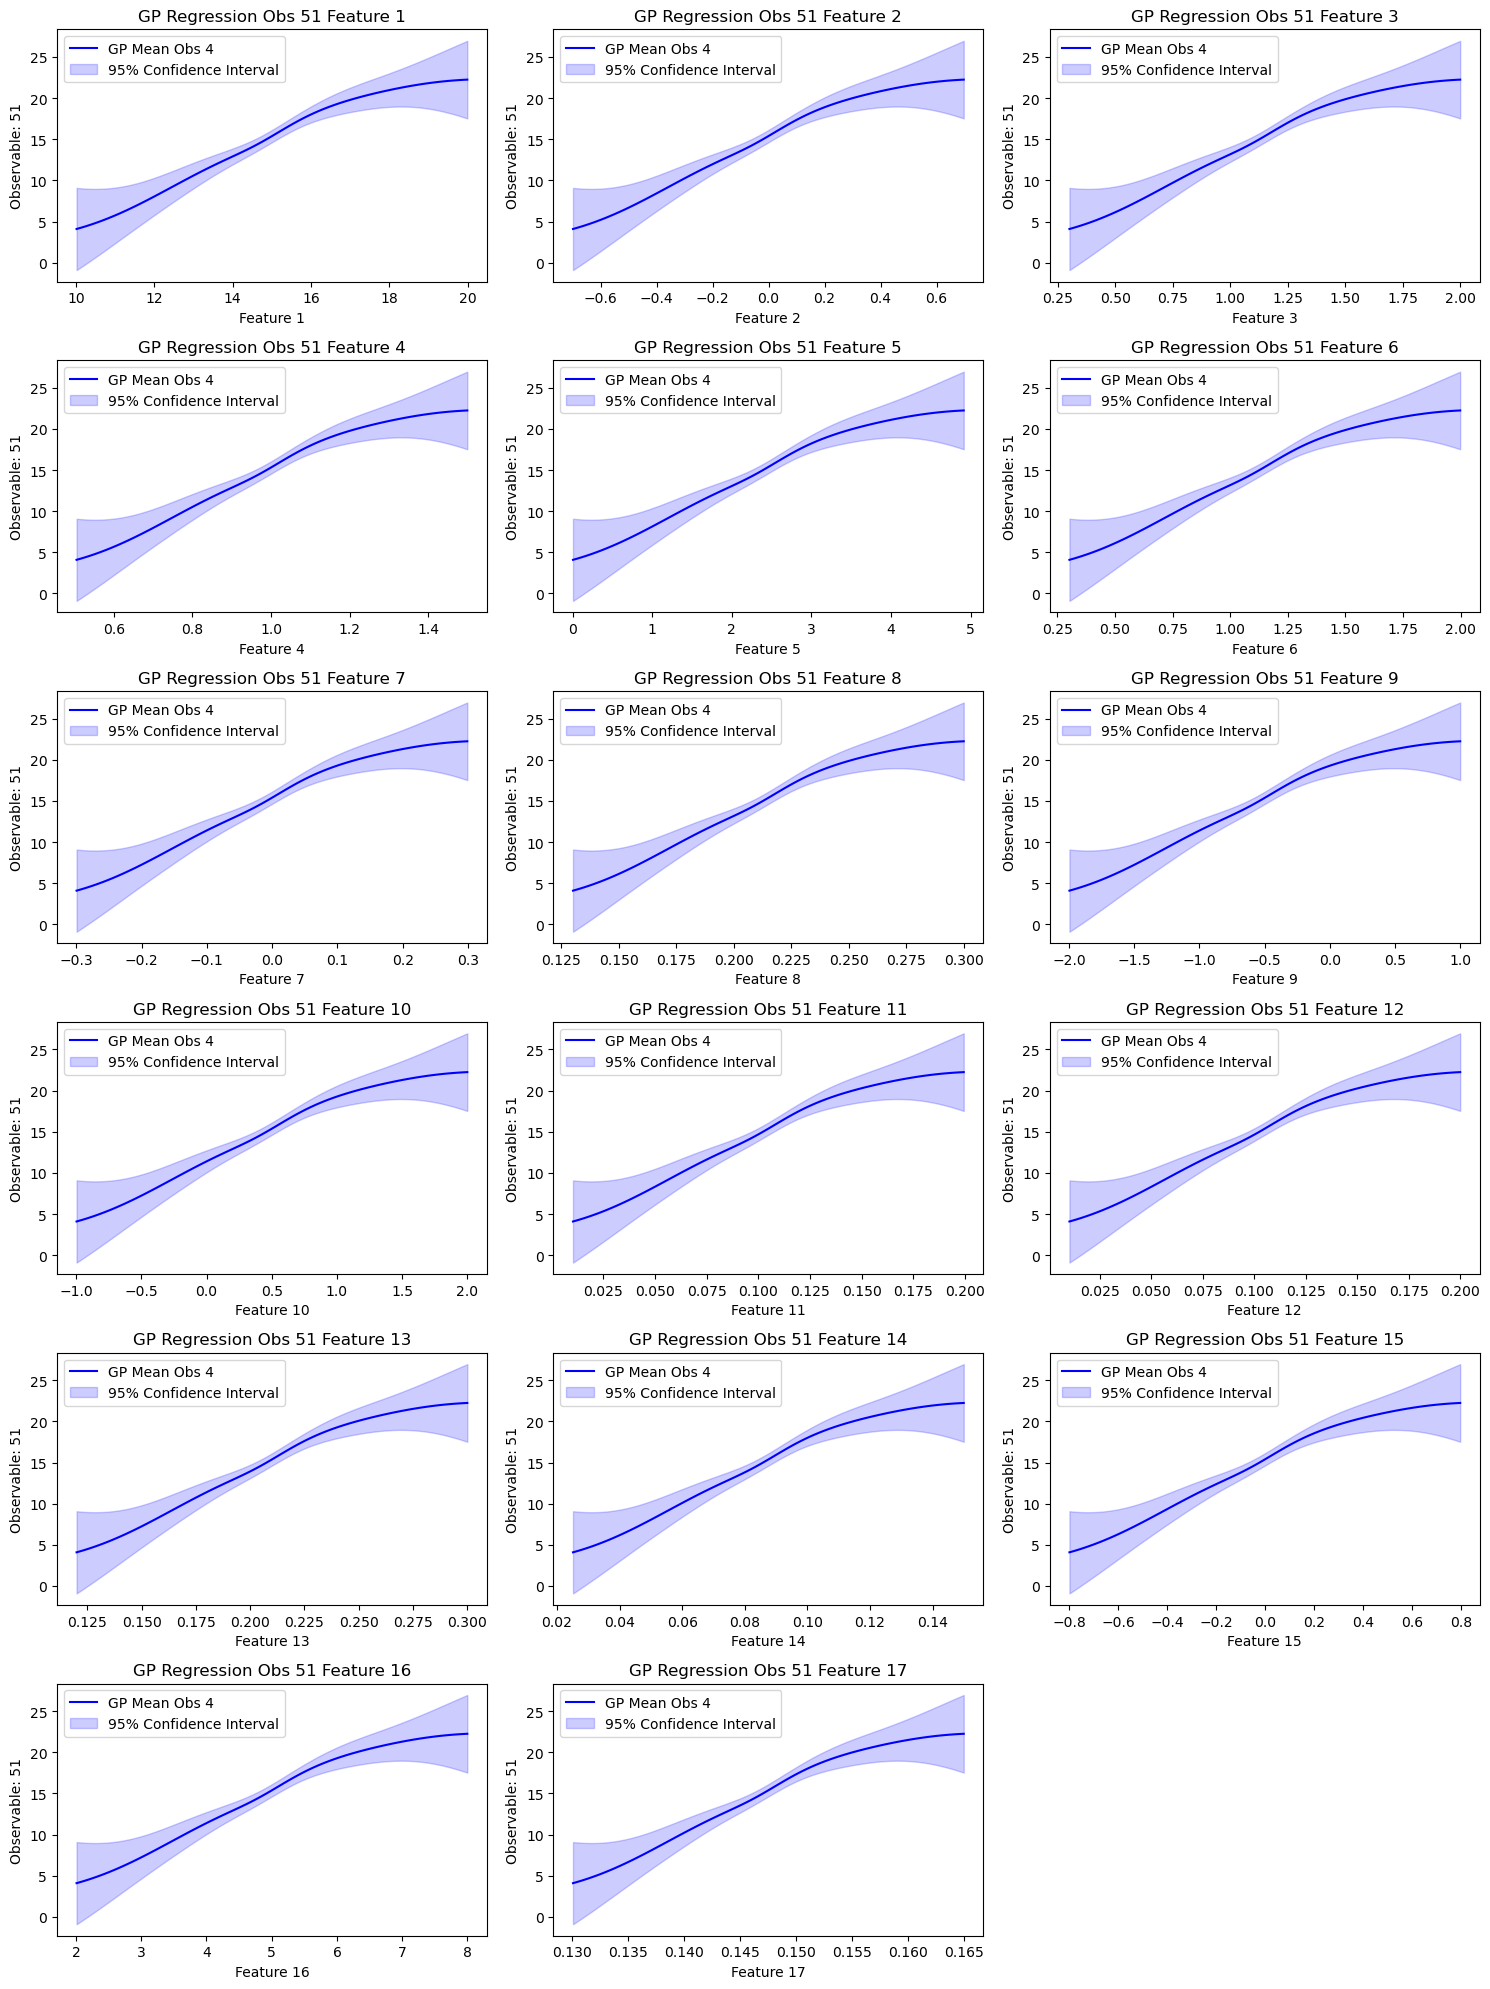

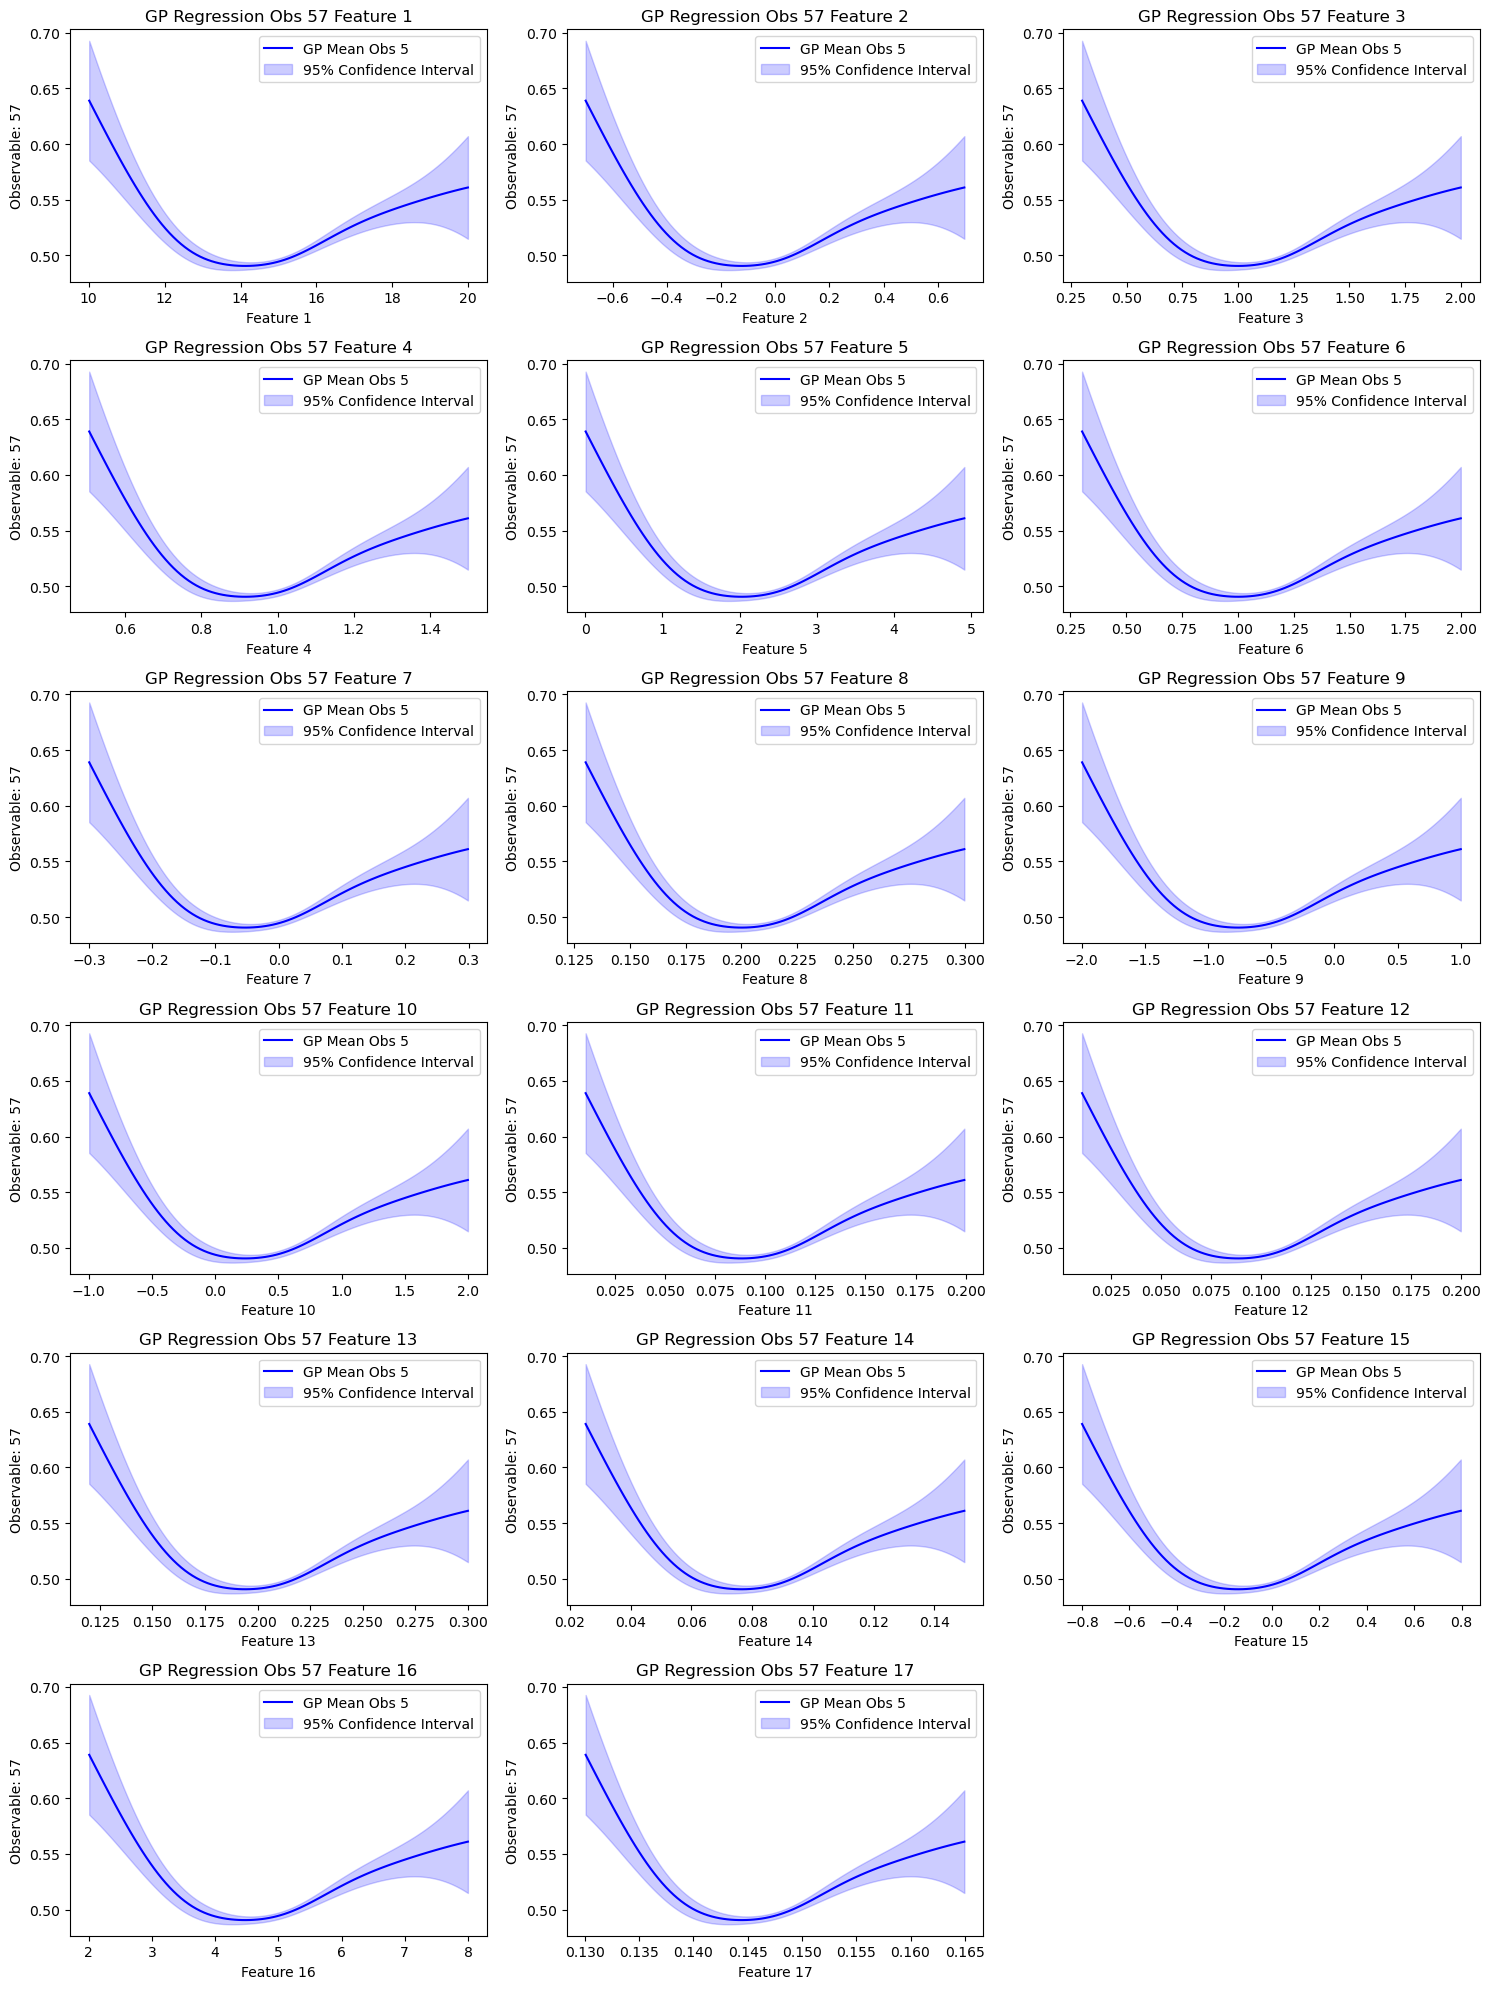

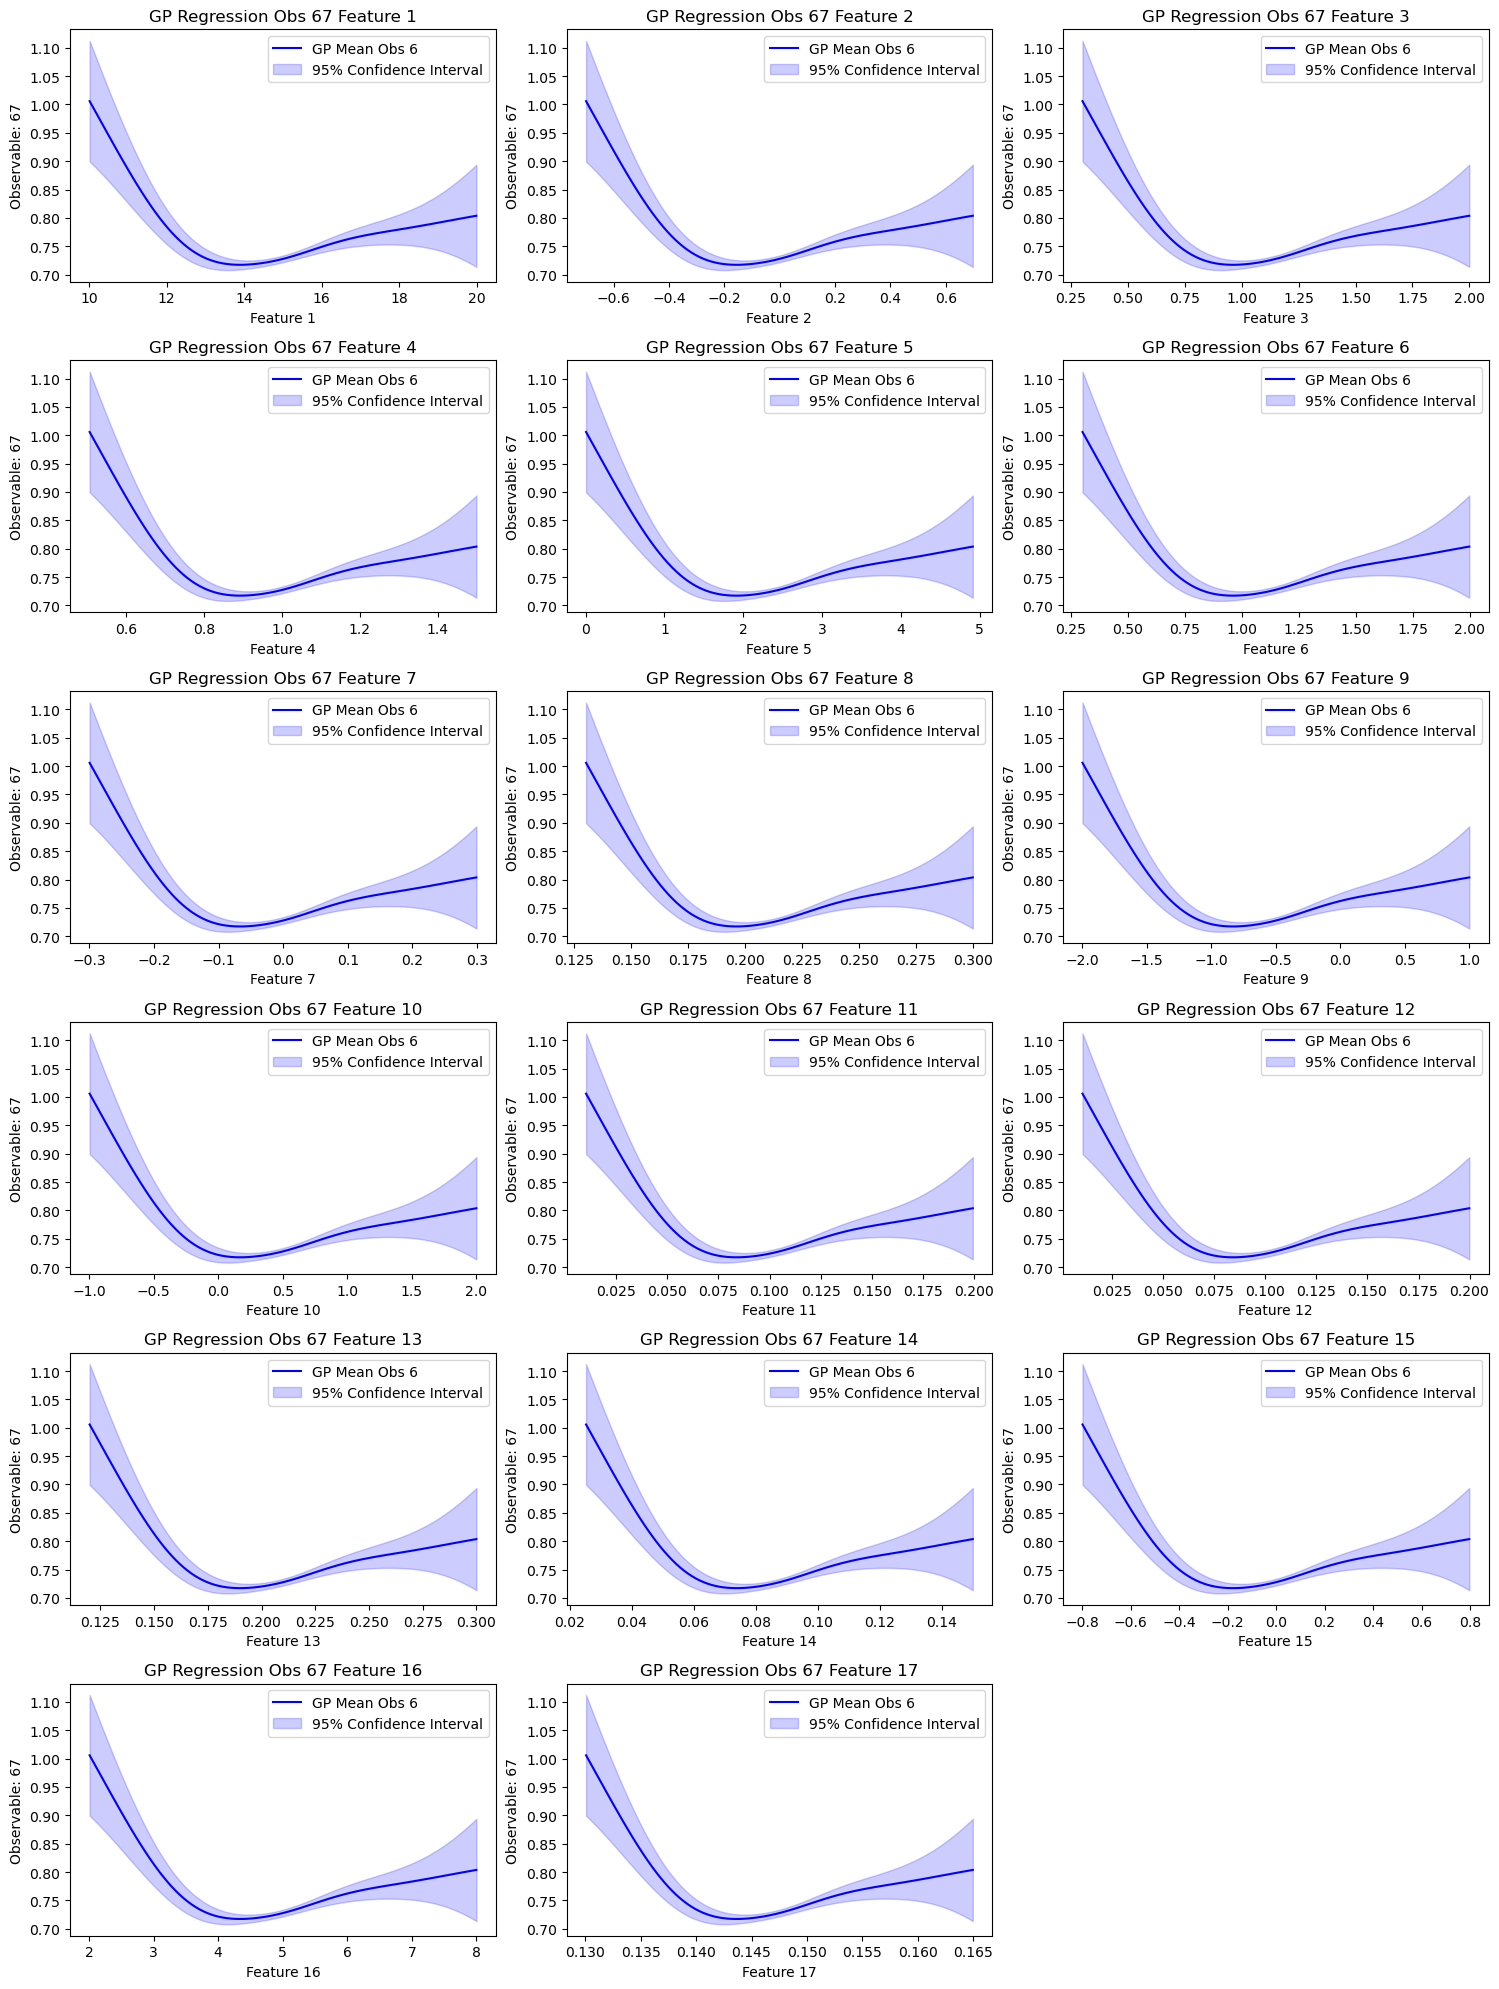

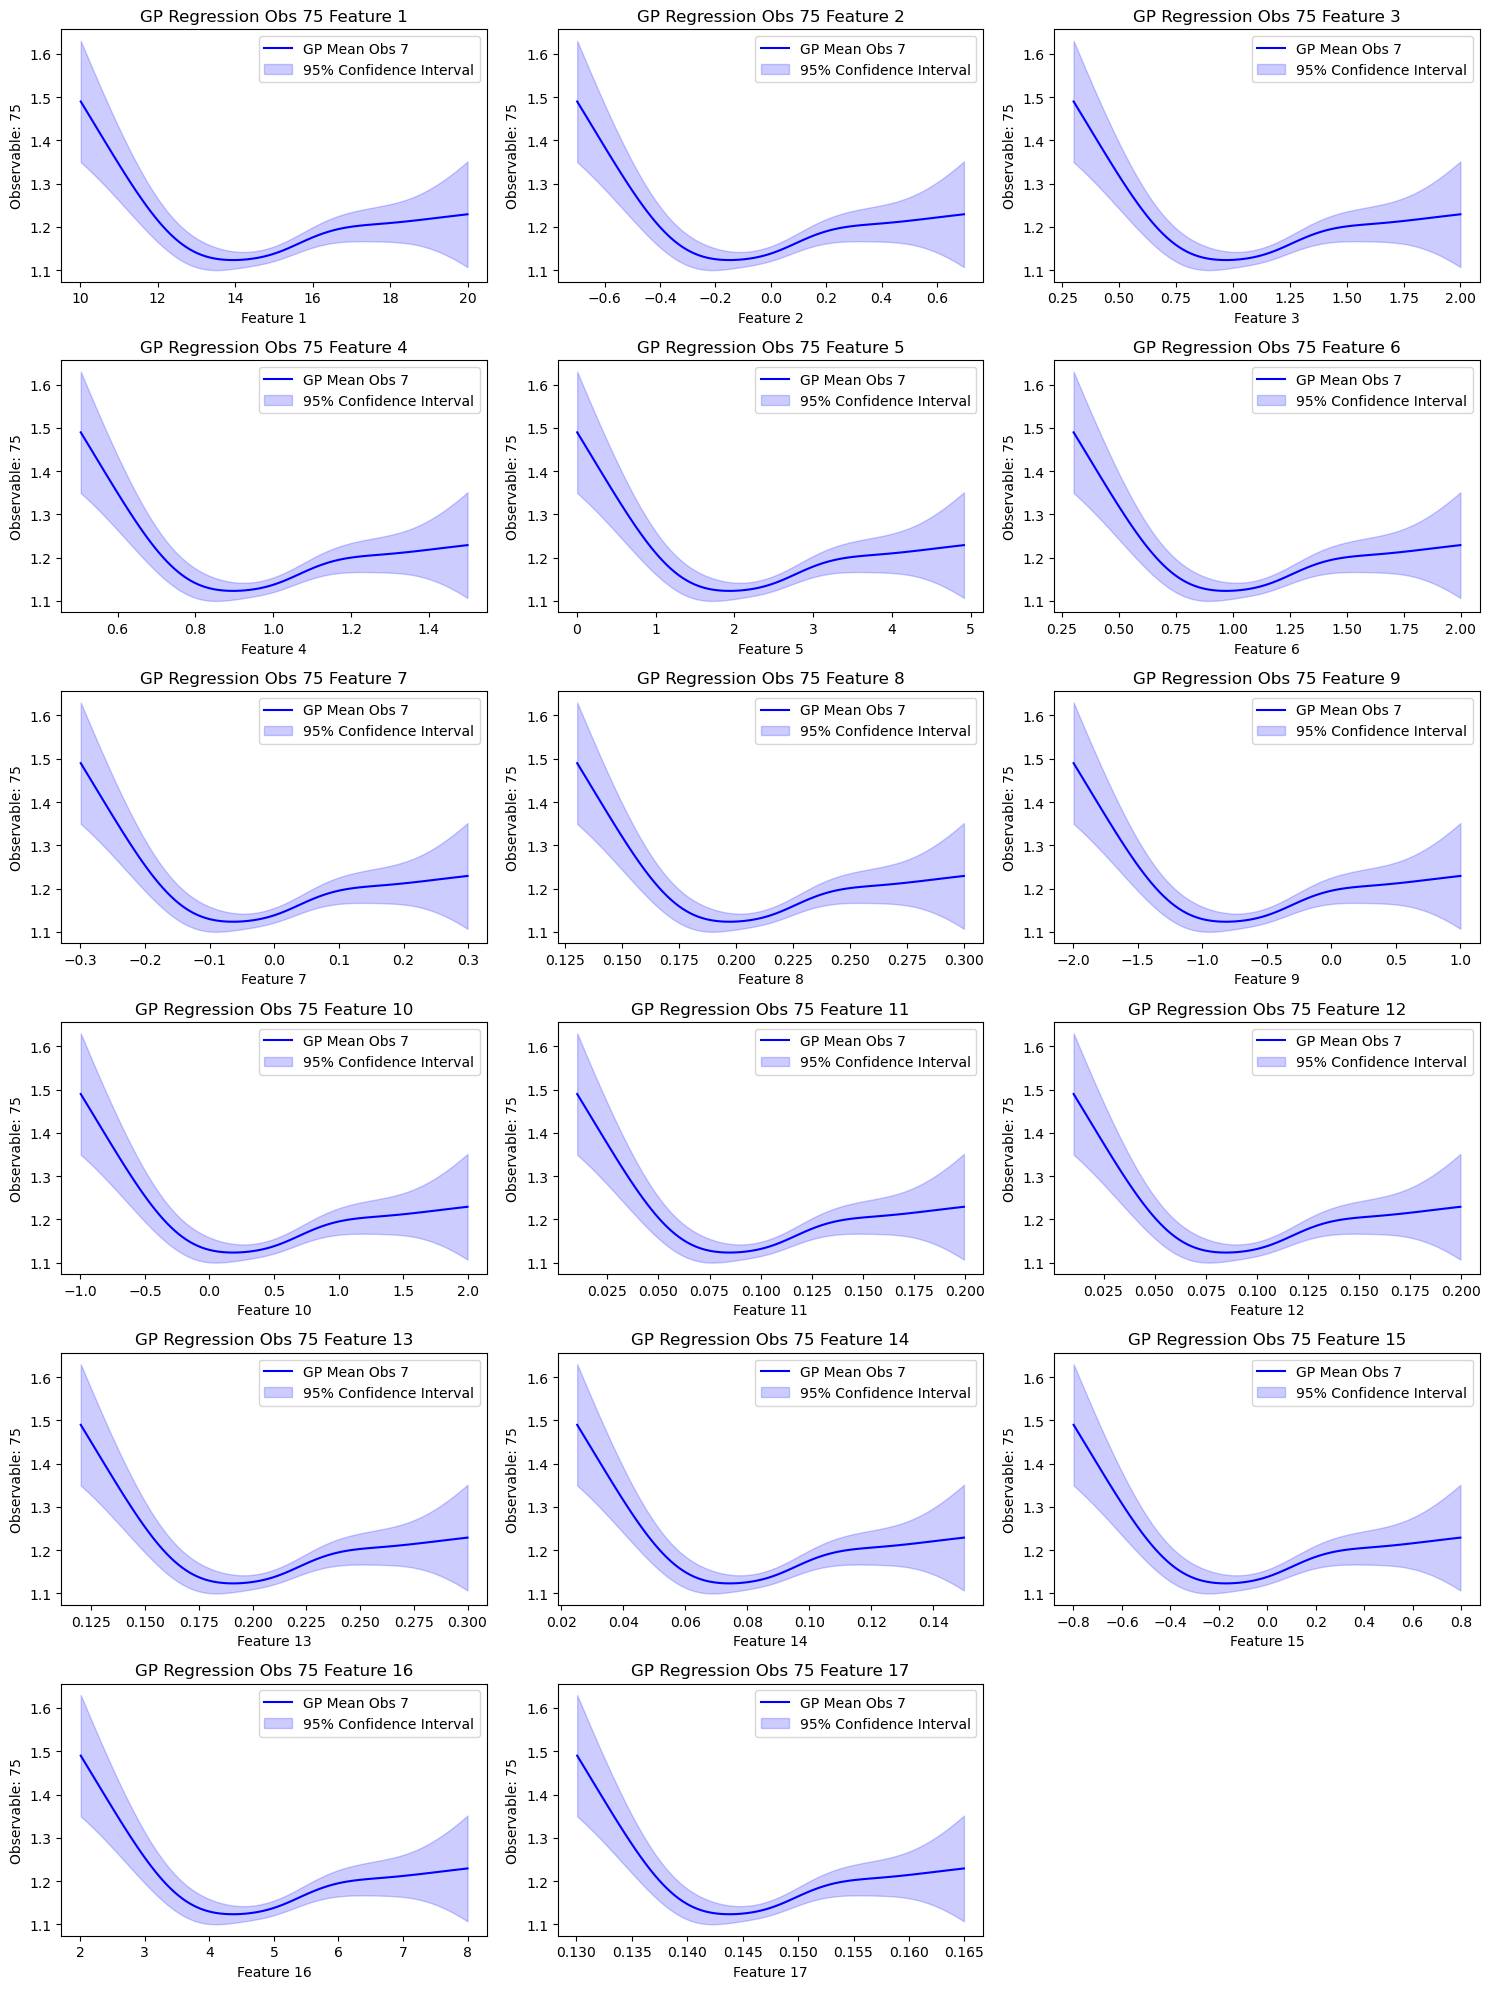

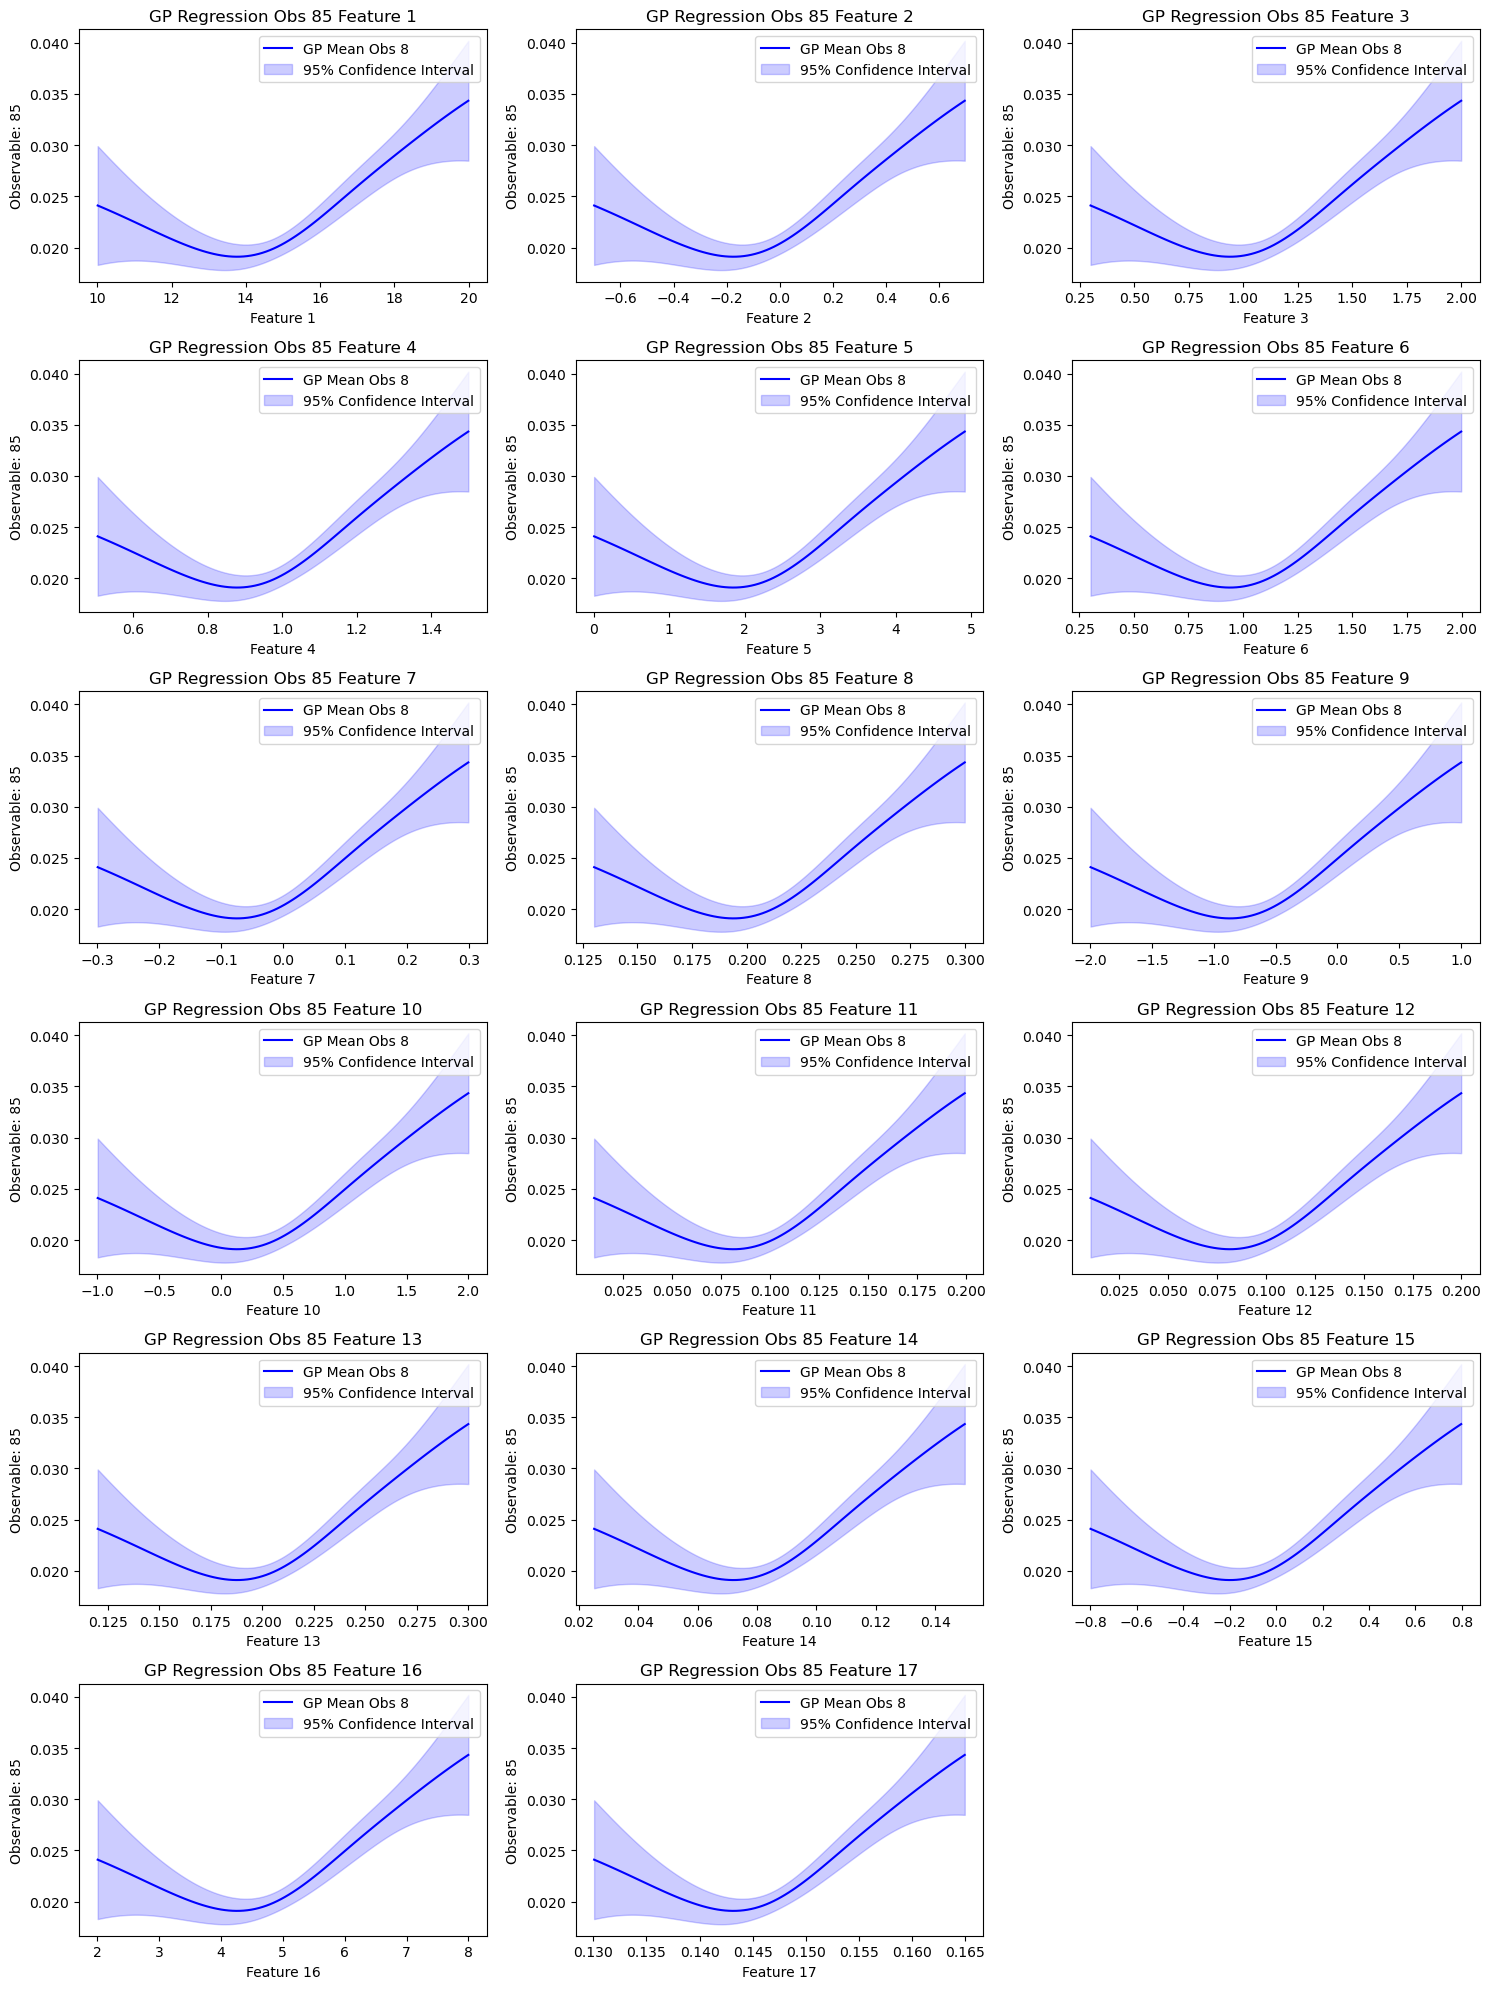

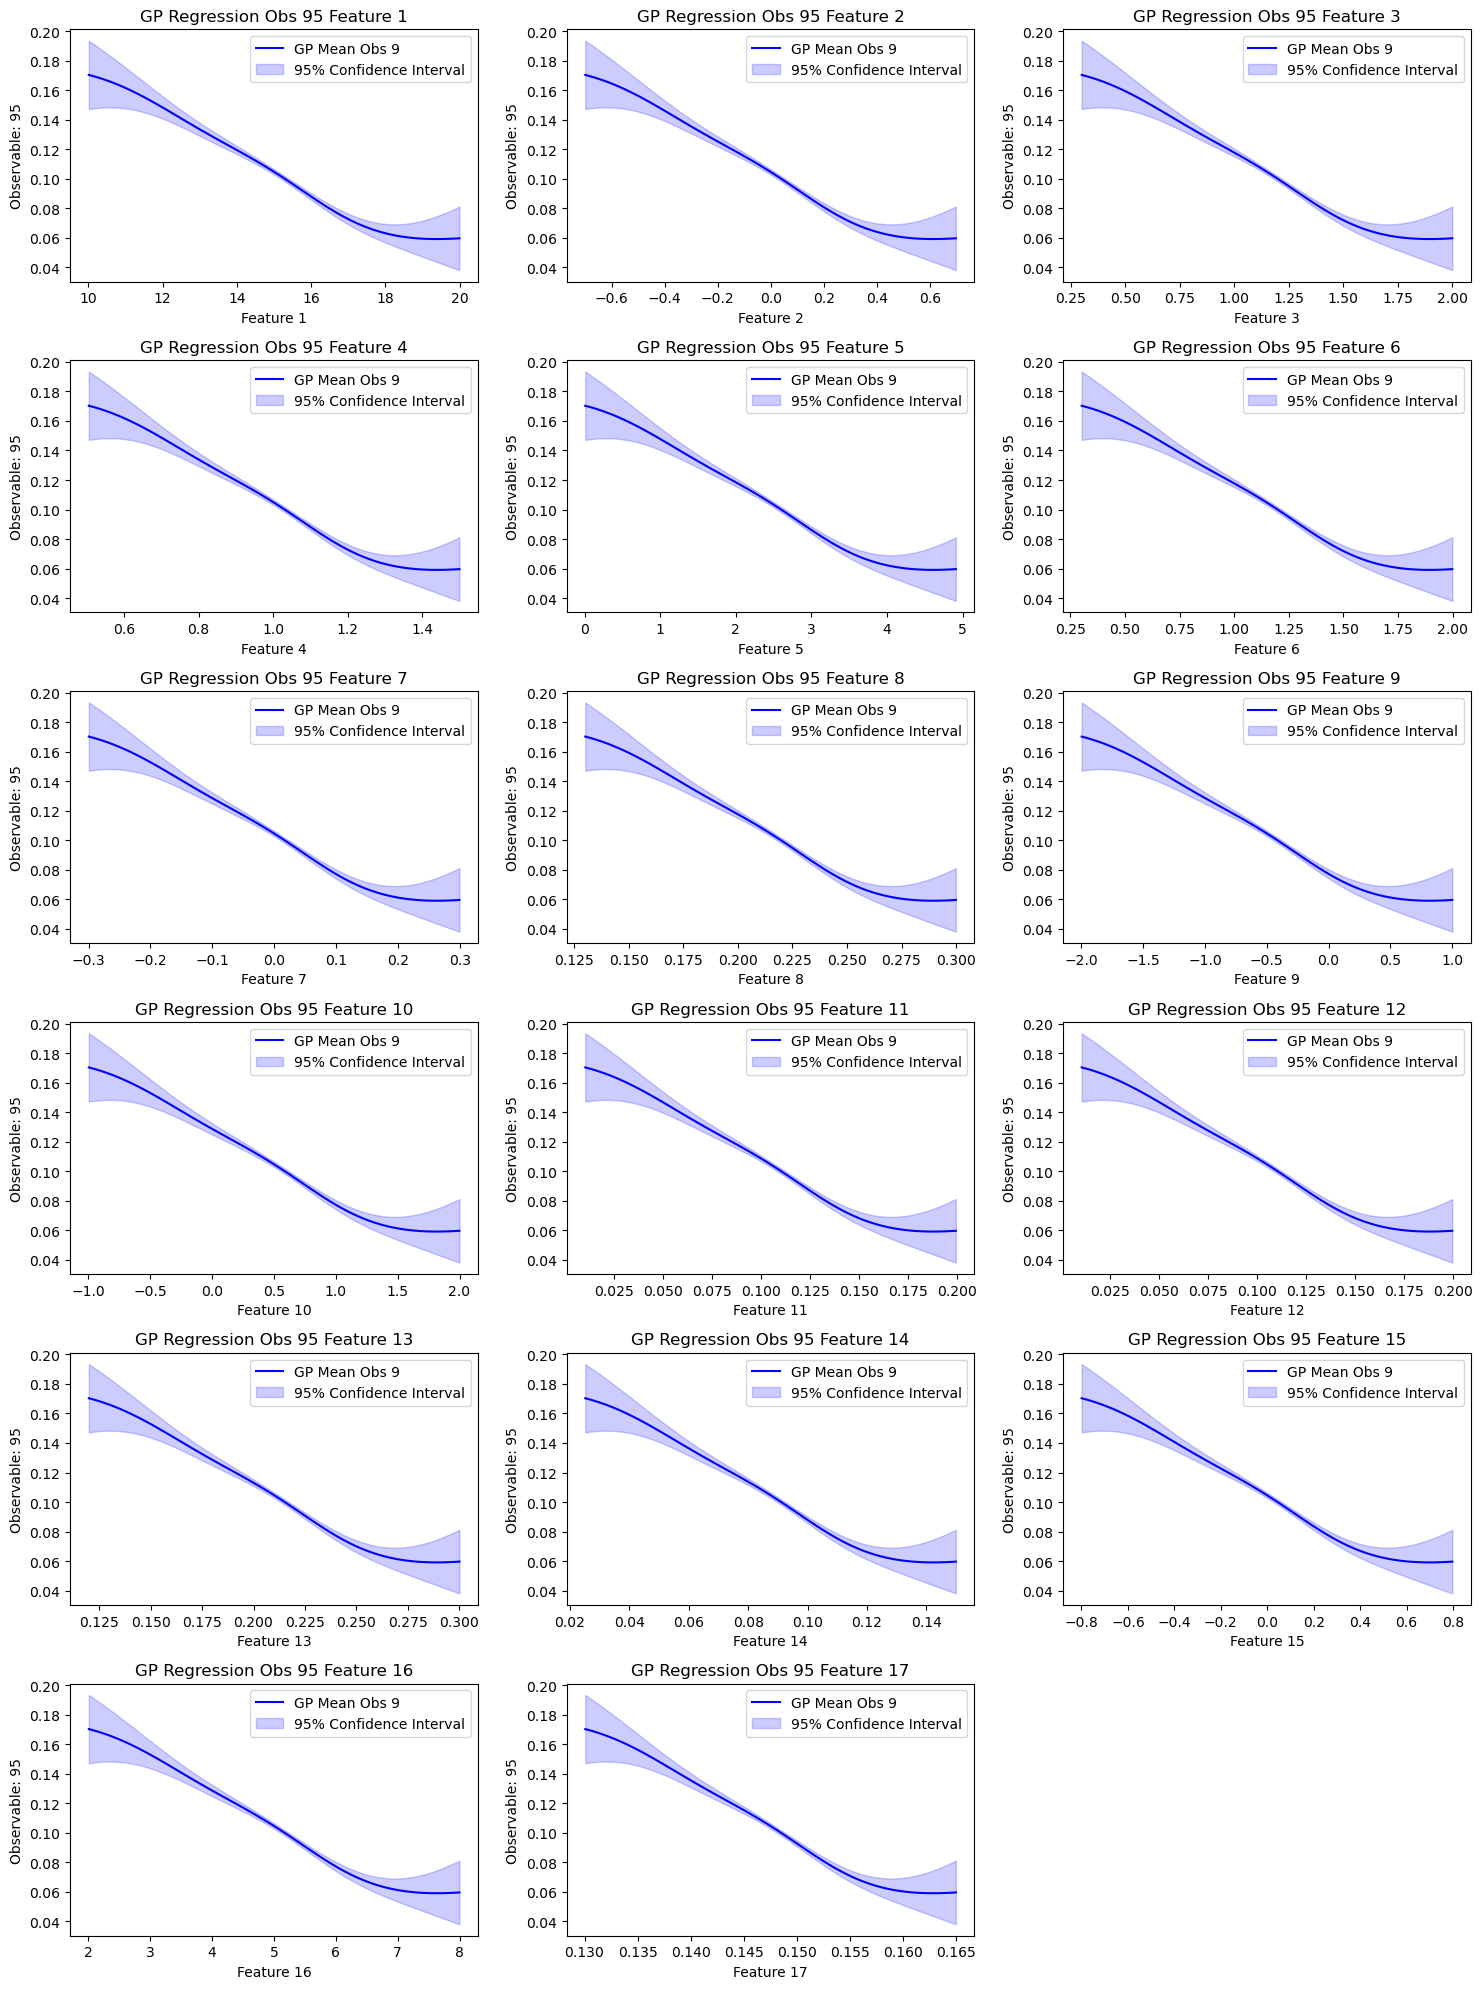

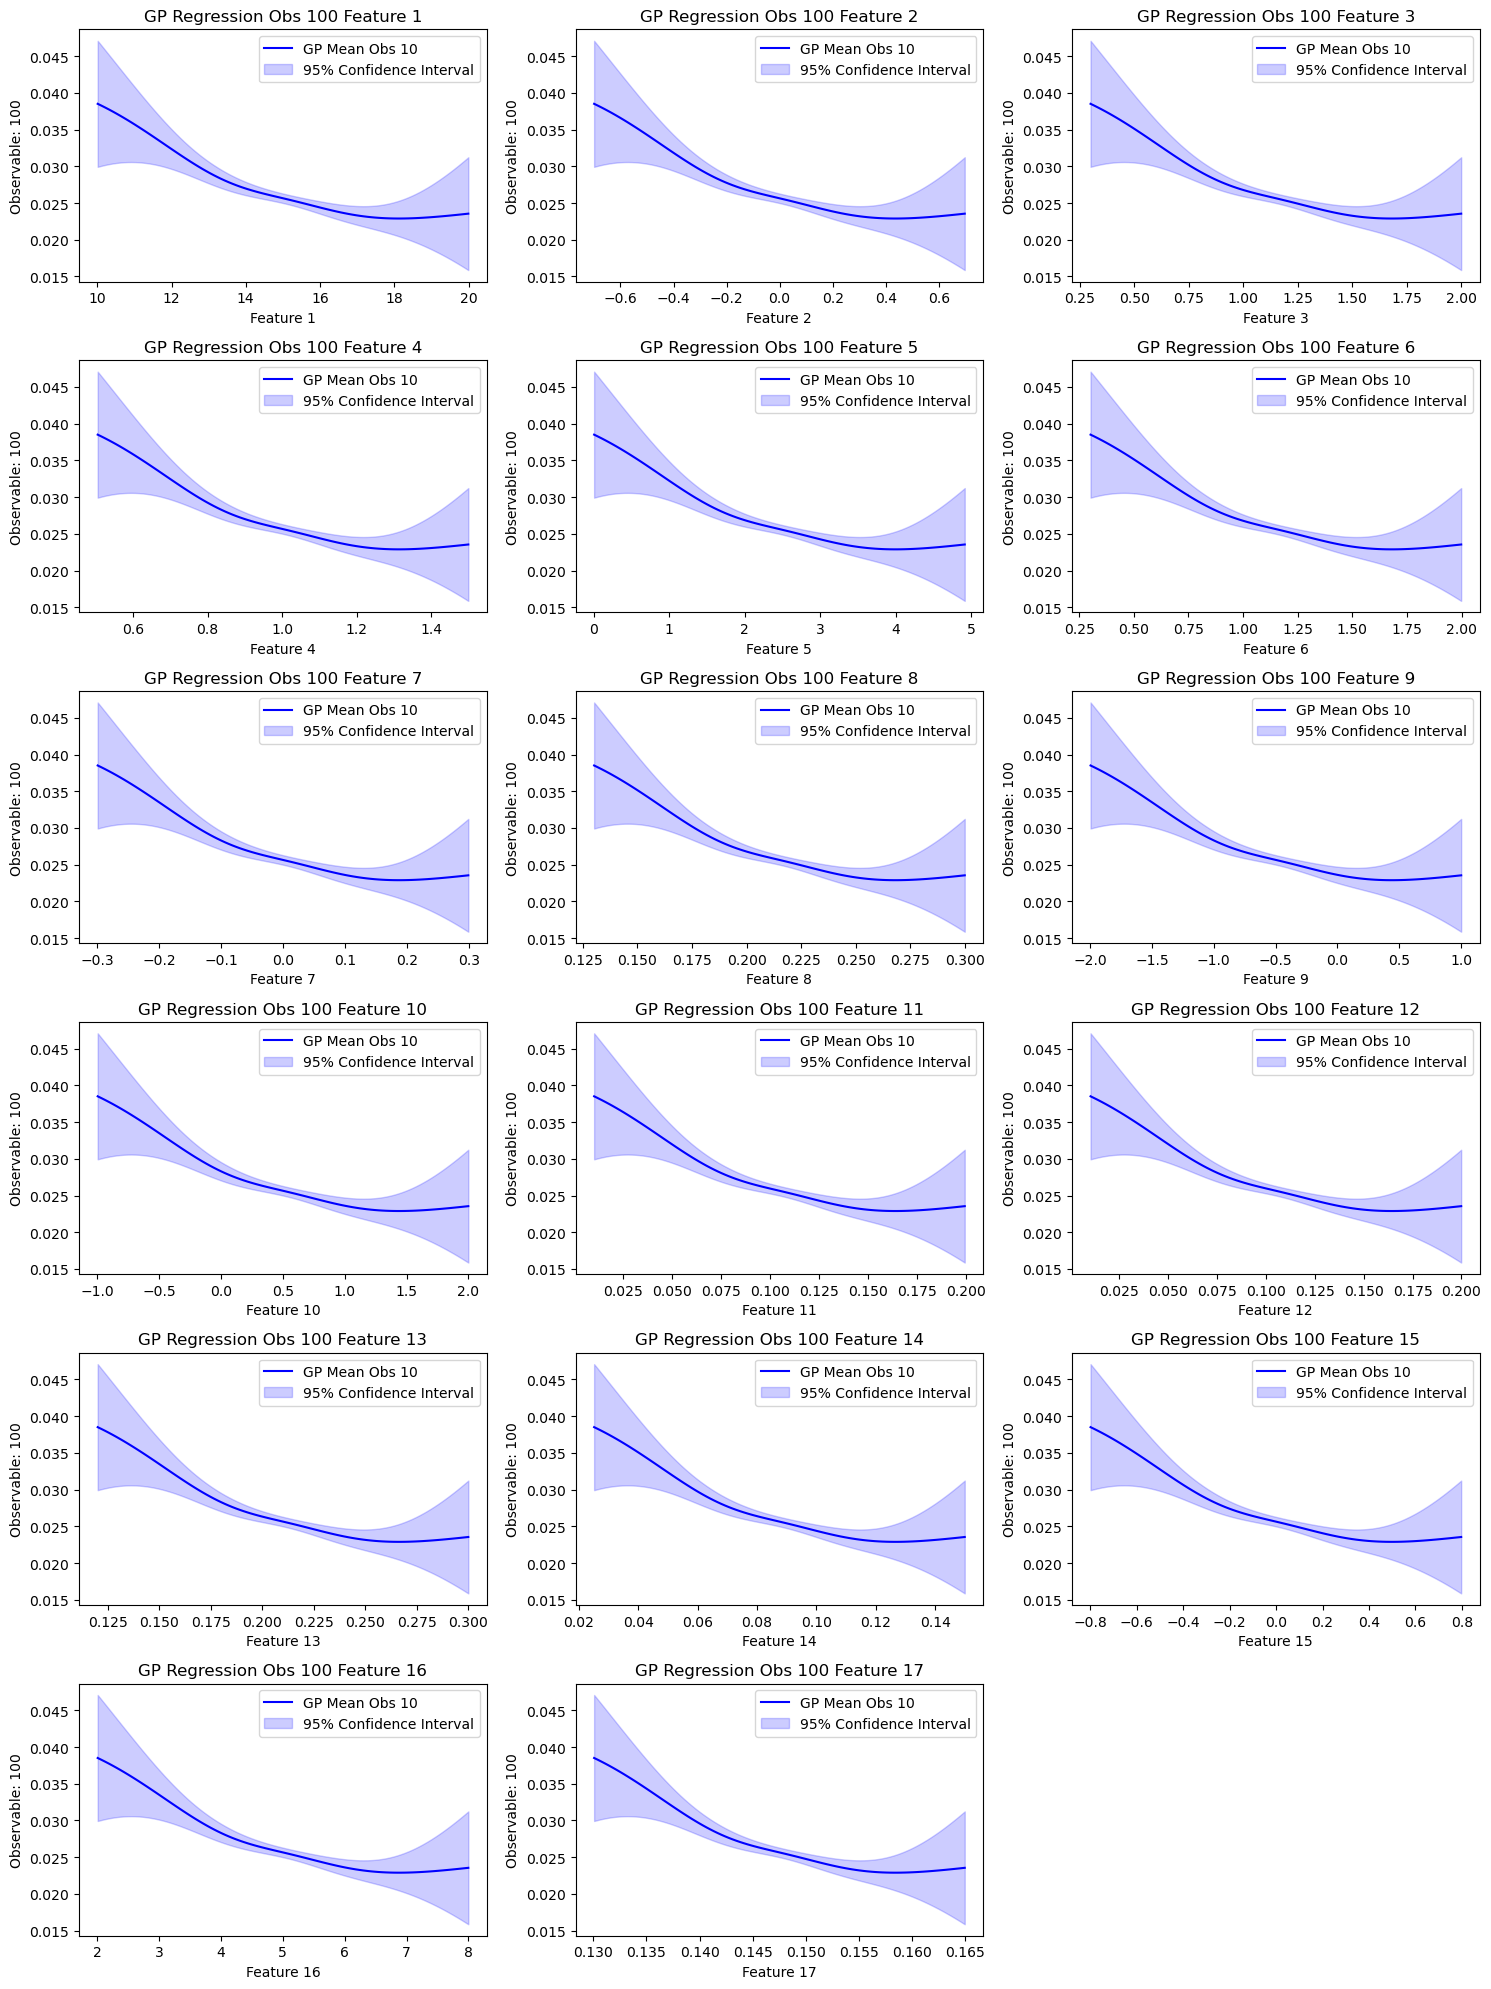

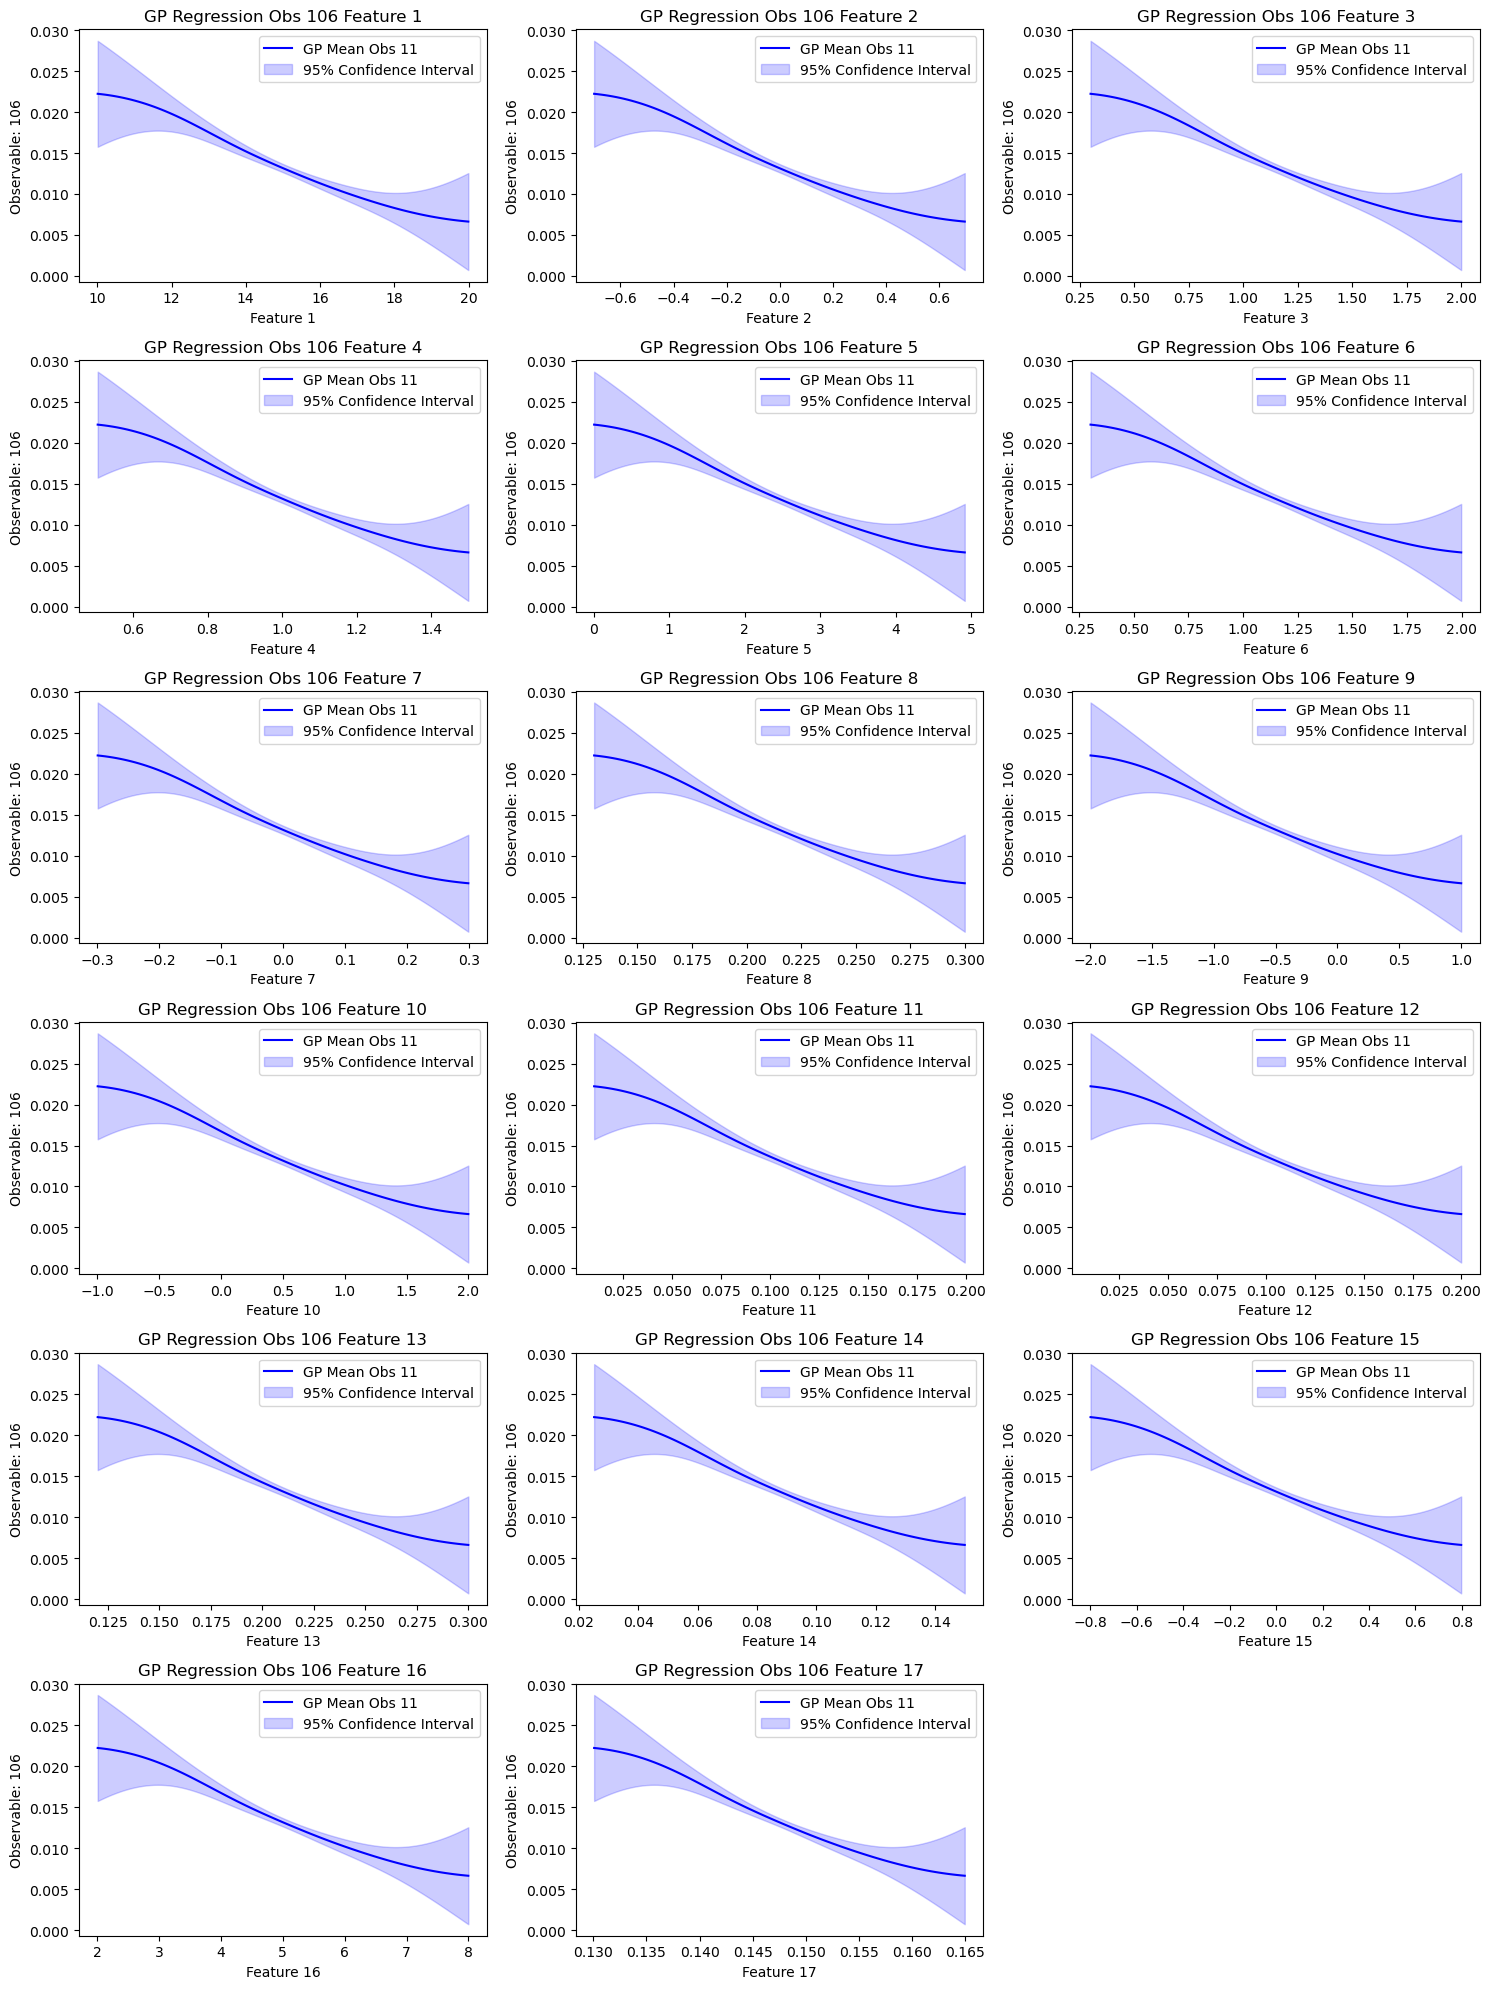

In [8]:
import matplotlib.pyplot as plt

# Set up the observation range
numobs = (5, 23, 33, 40, 51, 57, 67, 75, 85, 95, 100, 106)
obs_range = range(len(numobs))  # This will generate obs_no from 0 to 9
n_features = X.shape[1]  # Number of features

# Loop through each obs_no
for obs_no in obs_range:
    # Set up the subplots for the current obs_no
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
    axes = axes.flatten()
    # print("Observable: ", numobs[obs_no], "\n")
    # Loop through each feature
    for param_no in range(n_features):
        axes[param_no].plot(X_test[:, param_no], y_pred[:, obs_no], 'b-', label=f'GP Mean Obs {obs_no}')
        
        # Fill confidence interval for the current feature
        axes[param_no].fill_between(X_test[:, param_no], 
                                    y_pred[:, obs_no] - 1.96 * y_std[:, obs_no], 
                                    y_pred[:, obs_no] + 1.96 * y_std[:, obs_no], 
                                    alpha=0.2, color='blue', label='95% Confidence Interval')
        
        axes[param_no].set_xlabel(f'Feature {param_no + 1}')
        axes[param_no].set_ylabel(f'Observable: {numobs[obs_no]}')
        axes[param_no].set_title(f'GP Regression Obs {numobs[obs_no]} Feature {param_no + 1}')
        axes[param_no].legend()

    # Remove any empty subplots if fewer than 18 features
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
